# A. Data Wrangling

# 1. Purpose of This Data Science Project

The purpose of this data science project is to develop a pricing model for rents listed on rental postings. Property owners would benefit from listing their property at an appropriate price and in line with their position in the market. Owners would also benefit from insights to high-value versus low-value features.

# 2. Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.options.display.max_columns = None
import missingno as msno
from pandas_profiling.utils.cache import cache_file
from datetime import datetime
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

C:\Users\zebin\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 3. Objectives of This Notebook

In this step of the Data Science Method our focus is on wrangling data. This means that will collect data that will help us create a pricing tool, and determine if this data is sufficient to do so. Furthermore, we will correct any errors we find that may adversely affect subsequent analysis steps.

# 4. Loading Data

In [2]:
#Load data from folder
immo_data= pd.read_csv('../data/raw/immo_data.csv')

In [3]:
#Create a copy of data
rentals = immo_data.copy()

In [4]:
#Check basic information on the data
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   regio1                    268850 non-null  object 
 1   serviceCharge             261941 non-null  float64
 2   heatingType               223994 non-null  object 
 3   telekomTvOffer            236231 non-null  object 
 4   telekomHybridUploadSpeed  45020 non-null   float64
 5   newlyConst                268850 non-null  bool   
 6   balcony                   268850 non-null  bool   
 7   picturecount              268850 non-null  int64  
 8   pricetrend                267018 non-null  float64
 9   telekomUploadSpeed        235492 non-null  float64
 10  totalRent                 228333 non-null  float64
 11  yearConstructed           211805 non-null  float64
 12  scoutId                   268850 non-null  int64  
 13  noParkSpaces              93052 non-null   f

In [5]:
#Preview data
rentals.head()

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date
0,Nordrhein_Westfalen,245.00,central_heating,ONE_YEAR_FREE,NaN,False,False,6,4.62,10.0,840.0,1965.0,96107057,1.0,oil,False,Nordrhein_Westfalen,True,2.0,595.0,244,86.00,Dortmund,well_kept,normal,NaN,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,False,4,ground_floor,44269,4.0,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaN,NaN,NaN,NaN,May19
1,Rheinland_Pfalz,134.00,self_contained_central_heating,ONE_YEAR_FREE,NaN,False,True,8,3.47,10.0,NaN,1871.0,111378734,2.0,gas,False,Rheinland_Pfalz,False,1.0,800.0,NaN,89.00,Rhein_Pfalz_Kreis,refurbished,normal,no,no_information,NaN,False,5,ground_floor,67459,3.0,NaN,NaN,NaN,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,NaN,2019.0,NaN,NaN,May19
2,Sachsen,255.00,floor_heating,ONE_YEAR_FREE,10.0,True,True,8,2.72,2.4,1300.0,2019.0,113147523,1.0,NaN,False,Sachsen,True,9.0,965.0,4,83.80,Dresden,first_time_use,sophisticated,NaN,Turnerweg,Turnerweg,True,6,apartment,1097,3.0,NaN,3.0,4.0,3,False,4,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaN,NaN,NaN,NaN,Oct19
3,Sachsen,58.15,district_heating,ONE_YEAR_FREE,NaN,False,True,9,1.53,40.0,NaN,1964.0,108890903,NaN,district_heating,False,Sachsen,False,2.0,343.0,35,58.15,Mittelsachsen_Kreis,NaN,NaN,NaN,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,False,2,other,9599,3.0,86.0,3.0,NaN,3,False,2,Mittelsachsen_Kreis,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaN,NaN,NaN,NaN,May19
4,Bremen,138.00,self_contained_central_heating,NaN,NaN,False,True,19,2.46,NaN,903.0,1950.0,114751222,NaN,gas,False,Bremen,False,1.0,765.0,10,84.97,Bremen,refurbished,NaN,NaN,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,False,5,apartment,28213,3.0,188.9,1.0,NaN,3,False,4,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaN,NaN,NaN,NaN,Feb20


# 5. Explore Data

## 5.1 Datetime Features

The steps above showed that the following features - yearConstructed, lastRefurbish and date - were of a float64 data type. We will convert these features to a datetime format.

In [6]:
#Convert yearConstructed, lastRefurbish and date to datetime
rentals.yearConstructed = pd.to_datetime(rentals.yearConstructed, format = '%Y', errors = 'coerce')
rentals.lastRefurbish = pd.to_datetime(rentals.lastRefurbish, format = '%Y', errors = 'coerce')
rentals.date = pd.to_datetime(rentals.date, format = '%b%y')

In [7]:
#Verify datetime features
rentals.select_dtypes(include=[np.datetime64]).head(3)

,yearConstructed,lastRefurbish,date
0,1965-01-01,NaT,2019-05-01
1,1871-01-01,2019-01-01,2019-05-01
2,2019-01-01,NaT,2019-10-01


In [8]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268850 entries, 0 to 268849
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   regio1                    268850 non-null  object        
 1   serviceCharge             261941 non-null  float64       
 2   heatingType               223994 non-null  object        
 3   telekomTvOffer            236231 non-null  object        
 4   telekomHybridUploadSpeed  45020 non-null   float64       
 5   newlyConst                268850 non-null  bool          
 6   balcony                   268850 non-null  bool          
 7   picturecount              268850 non-null  int64         
 8   pricetrend                267018 non-null  float64       
 9   telekomUploadSpeed        235492 non-null  float64       
 10  totalRent                 228333 non-null  float64       
 11  yearConstructed           211414 non-null  datetime64[ns]
 12  sc

## 5.2 Reviewing Data Completeness

In [9]:
#To determine counts and percentage of valid entries
missing = pd.concat([rentals.isnull().sum(), rentals.isnull().mean() * 100], axis = 1)
missing.columns = ['num_mssg', 'pct_mssg']
missing.sort_values(by = 'num_mssg', ascending = False)

,num_mssg,pct_mssg
telekomHybridUploadSpeed,223830,83.254603
electricityKwhPrice,222004,82.575414
electricityBasePrice,222004,82.575414
energyEfficiencyClass,191063,71.066766
lastRefurbish,188145,69.981402
heatingCosts,183332,68.191185
noParkSpaces,175798,65.388879
petsAllowed,114573,42.615957
interiorQual,112665,41.906267
thermalChar,106506,39.615399


In [10]:
# Create list of missing categorical and numerical features
mssg_feat = list(rentals.columns[rentals.isnull().any()])
mssg_cat = list(rentals.select_dtypes('object').columns[rentals.select_dtypes('object').isnull().any()])
mssg_num = list(rentals.select_dtypes(['int64', 'float64']).columns[rentals.select_dtypes(['int64', 'float64',]).isnull().any()])
mssg_date = list(rentals.select_dtypes(['datetime64']).columns[rentals.select_dtypes(['datetime64']).isnull().any()])
print(f'Number of features with missing values: {len(mssg_feat)}')
print(f'Number of categorical features with missing values: {len(mssg_cat)}')
print(f'Number of numerical features with missing values: {len(mssg_num)}')
print(f'Number of datetime features with missing values: {len(mssg_date)}')

Number of features with missing values: 27
Number of categorical features with missing values: 12
Number of numerical features with missing values: 13
Number of datetime features with missing values: 2


We note that over 50% of our features have missing values and to various degrees. Features with many missing values and no imputation solutions are unlikely to help us develop a representative model; these will be dropped.

## 5.3 Checking for Duplicated Rental Units 

In [11]:
#Check for duplicates across all columns except scoutId which is the unique identifier for each listing
rentals_noScoutId = rentals.loc[:, rentals.columns != 'scoutId']
duplicates = rentals_noScoutId.duplicated()
duplicates.sum()

891

There are potentially 900 duplicated rows. We will review the nature of the duplicated rows.

In [12]:
#Check duplicated rows by reviewing the address information together with apartment characteristics.
address_cols = ['houseNumber', 'streetPlain','regio3', 'regio2','regio1','geo_plz']
rent_cols = ['baseRent', 'totalRent']
space_cols = ['noRooms', 'livingSpace']
select = address_cols + rent_cols + space_cols + ['date']
full_duplicates = rentals_noScoutId.duplicated(keep = False) #See duplicates
rentals.loc[full_duplicates, select].sort_values(by = ['baseRent', 'streetPlain']).head(10)

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date
6601,NaN,NaN,Merseburg,Saalekreis,Sachsen_Anhalt,6217,35.00,35.00,1.0,0.00,2019-05-01
34612,NaN,NaN,Merseburg,Saalekreis,Sachsen_Anhalt,6217,35.00,35.00,1.0,0.00,2019-05-01
69129,21,Margaretenstr.,Hilbersdorf,Chemnitz,Sachsen,9131,90.00,140.00,1.0,20.00,2019-10-01
262099,21,Margaretenstr.,Hilbersdorf,Chemnitz,Sachsen,9131,90.00,140.00,1.0,20.00,2019-10-01
67992,2b,Leipziger_Straße,Markranstädt,Leipzig_Kreis,Sachsen,4420,131.00,NaN,1.0,19.93,2019-05-01
226684,2b,Leipziger_Straße,Markranstädt,Leipzig_Kreis,Sachsen,4420,131.00,NaN,1.0,19.93,2019-05-01
104224,9,Hufelandstraße,Spremberger_Vorstadt,Cottbus,Brandenburg,3050,131.41,239.84,1.0,22.46,2020-02-01
207346,9,Hufelandstraße,Spremberger_Vorstadt,Cottbus,Brandenburg,3050,131.41,239.84,1.0,22.46,2020-02-01
42980,1,Dortmunder_Str.,Neuplanitz,Zwickau,Sachsen,8062,132.00,NaN,1.0,30.00,2019-10-01
198486,1,Dortmunder_Str.,Neuplanitz,Zwickau,Sachsen,8062,132.00,NaN,1.0,30.00,2019-10-01


In [13]:
#View duplicates in the last few roles
rentals.loc[full_duplicates, select].sort_values(by = ['baseRent', 'streetPlain']).tail(10)

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date
239746,236,Kurfürstendamm,Charlottenburg_Charlottenburg,Berlin,Berlin,10719,4100.0,5150.0,4.0,225.00,2019-05-01
248515,236,Kurfürstendamm,Charlottenburg_Charlottenburg,Berlin,Berlin,10719,4100.0,5150.0,4.0,225.00,2019-05-01
45538,NaN,NaN,Weißensee_Weißensee,Berlin,Berlin,13086,4150.0,NaN,5.0,209.00,2019-10-01
183319,NaN,NaN,Weißensee_Weißensee,Berlin,Berlin,13086,4150.0,NaN,5.0,209.00,2019-10-01
82517,NaN,NaN,Grünwald,München_Kreis,Bayern,82031,4200.0,NaN,2.0,180.00,2018-09-01
84496,NaN,NaN,Grünwald,München_Kreis,Bayern,82031,4200.0,NaN,2.0,180.00,2018-09-01
138833,1,Invalidenstrasse,Mitte_Mitte,Berlin,Berlin,10115,4416.4,4747.6,3.0,110.41,2020-02-01
149128,1,Invalidenstrasse,Mitte_Mitte,Berlin,Berlin,10115,4416.4,4747.6,3.0,110.41,2020-02-01
142554,NaN,NaN,Westend_Süd,Frankfurt_am_Main,Hessen,60325,4500.0,NaN,6.0,225.00,2018-09-01
249898,NaN,NaN,Westend_Süd,Frankfurt_am_Main,Hessen,60325,4500.0,NaN,6.0,225.00,2018-09-01


The samples show that these rows are duplicated. We will go ahead and drop one out of the duplicated rows.

In [14]:
#Select all columns except for scoutId
column_names = rentals.loc[:, rentals.columns != 'scoutId'].columns

In [15]:
#Drop duplicated columns
rentals.drop_duplicates(subset = column_names, inplace = True)
rentals.shape

(267959, 49)

## 5.5 Reviewing Categorical Features
    
### 5.5.1 Address Information <br>(houseNumber, geo_bln, geo_krs, street, geo_plz, regio1, regio2,    regio3, streetPlain)</br>

In [16]:
address = ['houseNumber','street', 'streetPlain', 'regio3', 'regio2','geo_krs','regio1', 'geo_bln', 'geo_plz']
rentals[address].head()

,houseNumber,street,streetPlain,regio3,regio2,geo_krs,regio1,geo_bln,geo_plz
0,244,Sch&uuml;ruferstra&szlig;e,Schüruferstraße,Schüren,Dortmund,Dortmund,Nordrhein_Westfalen,Nordrhein_Westfalen,44269
1,NaN,no_information,NaN,Böhl_Iggelheim,Rhein_Pfalz_Kreis,Rhein_Pfalz_Kreis,Rheinland_Pfalz,Rheinland_Pfalz,67459
2,4,Turnerweg,Turnerweg,Äußere_Neustadt_Antonstadt,Dresden,Dresden,Sachsen,Sachsen,1097
3,35,Gl&uuml;ck-Auf-Stra&szlig;e,Glück-Auf-Straße,Freiberg,Mittelsachsen_Kreis,Mittelsachsen_Kreis,Sachsen,Sachsen,9599
4,10,Hermann-Henrich-Meier-Allee,Hermann-Henrich-Meier-Allee,Neu_Schwachhausen,Bremen,Bremen,Bremen,Bremen,28213


We notice that street seems identical to streetPlain, regio2 seems identical to geo_krs and regio1 seems identical to geo_bln. Let us review these relationships.

### regio1 and geo_bln

In [17]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio1"] != rentals['geo_bln']).sum() 

0

regio1 is the state and it is always equal to geo_bln. We will drop geo_bln

In [18]:
#Number of categories
rentals.regio1.nunique()

16

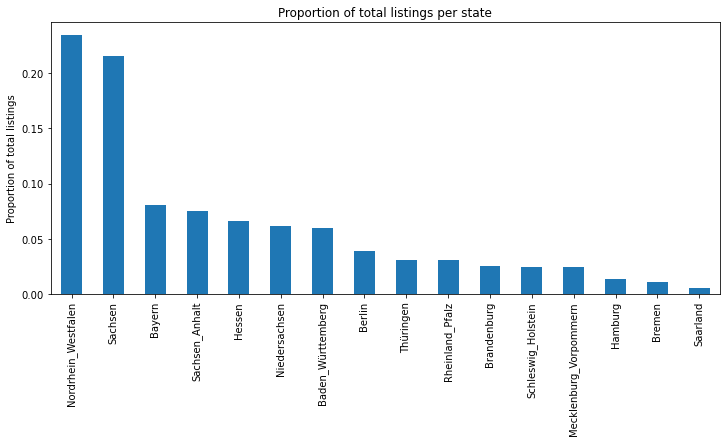

In [19]:
#View distribution of listings per state
plt.figure(figsize = (12, 5))
plt.title('Proportion of total listings per state')
rentals.regio1.value_counts(normalize = True, dropna = False).plot.bar()
plt.ylabel('Proportion of total listings');

We note that most of the available listings are in Northern_Westfalen and Sachsen. We note that states are nominal and therefore require some kind of encoding before a model can be developed.

### regio2 and geo_krs

In [20]:
#Check if there are records where regio1 is not identical to geo_bln 
(rentals["regio2"] != rentals['geo_krs']).sum() 

0

regio2 is the city / town and it is always equal to geo_krs. We will drop geo_krs.

In [21]:
#Number of categories
rentals.regio2.nunique()

419

In [22]:
rentals.regio2.unique()[:10]

array(['Dortmund', 'Rhein_Pfalz_Kreis', 'Dresden', 'Mittelsachsen_Kreis',
       'Bremen', 'Schleswig_Flensburg_Kreis', 'Emmendingen_Kreis',
       'Gelsenkirchen', 'Chemnitz', 'Südliche_Weinstraße_Kreis'],
      dtype=object)

We notice that some cities/towns have an alternative version of their names with a trailing "_Kreis". This leads to more dimensions than is required. We will remove this trailing term.

In [23]:
#Remove trailing _kreis
rentals.regio2 = rentals.regio2.str.replace('_Kreis', '')
rentals.regio2.nunique()

394

We have reduced the number of city/towns in regio2 from 419 to 394, but this is still high. 

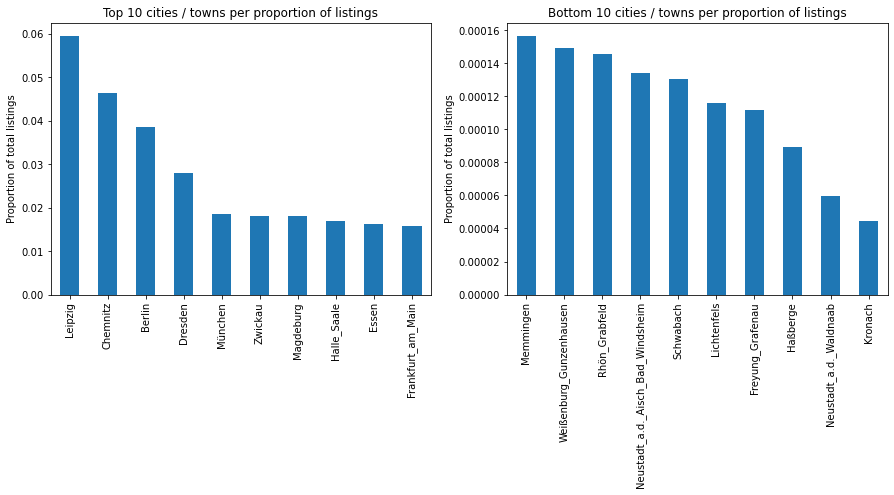

In [24]:
#View distribution of listings per city_town
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title('Top 10 cities / towns per proportion of listings')
rentals.regio2.value_counts(normalize = True)[:10].plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Bottom 10 cities / towns per proportion of listings')
rentals.regio2.value_counts(normalize = True)[-10:].plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

We observe that Leipzig has the most number of listings, while Kronach has the least number of listings in the dataset. The city/town is a nominal value, which requires encoding before modelling. However, if we create a country-level model, encoding the 394 cities/towns will increase the sparsity of the dateset. We need to transform the feature prior to encoding or drop the feature.

### street and streetPlain

In [25]:
#We can take a sample of street and streetPlain data to verify that they are identical
rentals[['street', 'streetPlain']].sample(5)

,street,streetPlain
223430,Sickingm&uuml;hlerstr.,Sickingmühlerstr.
161802,Georg-Friedrich-H&auml;ndel-Str.,Georg-Friedrich-Händel-Str.
6345,Oskar-Cohn-Stra&szlig;e,Oskar-Cohn-Straße
231561,Augsburger Str.,Augsburger_Str.
110661,Platanenstra&szlig;e,Platanenstraße


street and streetPlain are always identical. We will drop street.

In [26]:
#Number of categories
rentals.streetPlain.nunique() 

54490

In [27]:
#Review category names and how many records in which they appear
rentals.streetPlain.value_counts(normalize = True).head()

Hauptstraße         0.004620
Bahnhofstraße       0.004230
Leipziger_Straße    0.002155
Goethestraße        0.002059
Bahnhofstr.         0.002034
Name: streetPlain, dtype: float64

We note that the categories of streetPlain are nominal and that there are over 54,000 street names, which is very high. We believe that we can obtain key location information from the zip code rather than the street name. We will therefore be dropping this feature.

### regio3

- regio3 is the municipality

In [28]:
#Review category names and how many records in which they appear
rentals.regio3.nunique()

8684

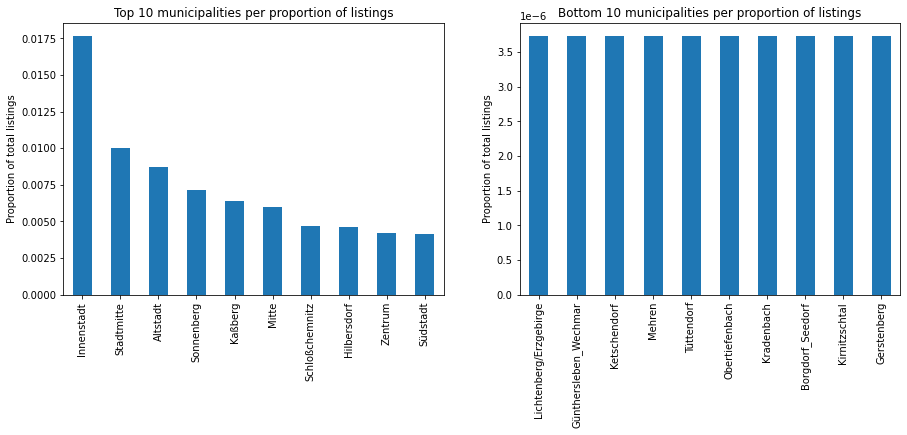

In [29]:
#View distribution of listings per municipality
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title('Top 10 municipalities per proportion of listings')
rentals.regio3.value_counts(normalize = True)[:10].plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Bottom 10 municipalities per proportion of listings')
rentals.regio3.value_counts(normalize = True)[-10:].plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

The categories of regio3 are nominal. There are 8,684 categories, which is very high. We need to transform this feature too one with a lower number of categories or drop this feature. 

### houseNumber

In [30]:
#Check count of house numbers
rentals.houseNumber.nunique()

5510

houseNumber is unlikely to give us any useful information as these numbers are typically arbitrary.

### geo_plz

geo_plz is the zip code of the property. Typically, high-priced properties are found in the same area code.

In [31]:
#Check count of geo_plz
rentals.geo_plz.nunique()

7634

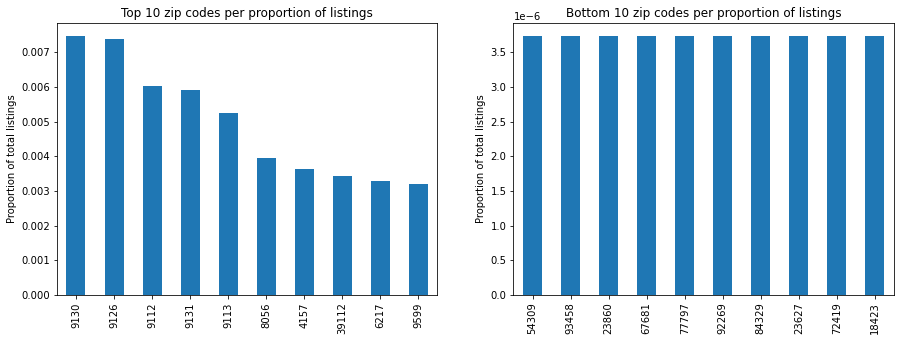

In [32]:
#View distribution of geo_plz
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title('Top 10 zip codes per proportion of listings')
rentals.geo_plz.value_counts(normalize = True)[:10].plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Bottom 10 zip codes per proportion of listings')
rentals.geo_plz.value_counts(normalize = True)[-10:].plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

The zip codes are nominal. There 7,634 zip codes, which is too high for a model. We need to transform the feature to one with less categories prior to encoding, or drop the feature. 

### 5.5.3 Reviewing Remaining Categorical Features

In [33]:
rentals.select_dtypes('object').describe()

,regio1,heatingType,telekomTvOffer,firingTypes,geo_bln,houseNumber,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,typeOfFlat,regio2,regio3,description,facilities,energyEfficiencyClass
count,267959,223249,235535,211206,267959,197175,267959,199633,155658,153802,267959,197180,231459,267959,267959,248272,215194,77537
unique,16,13,3,132,16,5510,419,10,4,3,52373,54490,10,394,8684,212621,189526,10
top,Nordrhein_Westfalen,central_heating,ONE_YEAR_FREE,gas,Nordrhein_Westfalen,1,Leipzig,well_kept,normal,negotiable,no_information,Hauptstraße,apartment,Leipzig,Innenstadt,+ MEIN GUENTZ - Quartier der Generationen\r\n+...,Laminat,C
freq,62744,128567,226948,110523,62744,7151,13653,66393,81652,91688,70779,911,131056,15964,4734,213,207,14593


#### 5.5.3.1 heatingType and firingTypes

In [34]:
#Review count of heatingType categories
rentals.heatingType.value_counts(dropna = False)

central_heating                   128567
NaN                                44710
district_heating                   24701
gas_heating                        19857
self_contained_central_heating     19055
floor_heating                      17618
oil_heating                         5042
heat_pump                           2734
combined_heat_and_power_plant       1972
night_storage_heater                1338
wood_pellet_heating                  958
electric_heating                     898
stove_heating                        343
solar_heating                        166
Name: heatingType, dtype: int64

In [35]:
#Check count of heatingType
rentals.heatingType.nunique()

13

In [36]:
#Check count of firingTypes
rentals.firingTypes.nunique()

132

In [37]:
#Check values for firingTypes
rentals.firingTypes.value_counts()[:20]

gas                                     110523
district_heating                         49192
oil                                      18115
natural_gas_light                        10059
electricity                               4829
natural_gas_heavy                         4535
pellet_heating                            2474
geothermal                                2429
gas:electricity                           1353
local_heating                              924
environmental_thermal_energy               896
combined_heat_and_power_fossil_fuels       860
steam_district_heating                     785
liquid_gas                                 451
solar_heating                              443
district_heating:electricity               439
heat_supply                                389
solar_heating:gas                          385
gas:district_heating                       258
wood_chips                                 191
Name: firingTypes, dtype: int64

We observe that in some instances, we have multiple values for the firingType separated by a colon (e.g. gas:electricity). We can determine if there are others like this.

In [38]:
#Find other firingTypes with multiple values
rentals.loc[rentals.firingTypes.str.contains(':', na = False), 'firingTypes'].head(10)

7                     gas:electricity
105                   gas:electricity
150    district_heating:local_heating
296              gas:district_heating
334                 solar_heating:gas
355                   gas:electricity
467             gas:natural_gas_light
517                 solar_heating:gas
692                 solar_heating:gas
719                   gas:electricity
Name: firingTypes, dtype: object

In [39]:
# Split the data on ':' to get a sense for the extent of the values
rentals["firingTypes"].str.split(":", expand = True).notnull().sum()

0     211206
1       3402
2         69
3         17
4          4
5          4
6          2
7          2
8          2
9          2
10         2
11         2
12         1
dtype: int64

- We note that the first column has most of the data. We will take the values of this first column as values for firingTypes

In [40]:
#Select only the first values for firingTypes with multiple values
rentals.firingTypes = rentals.firingTypes.str.split(':', expand = True)[0]

In [41]:
#Check count of firingTypes
rentals.firingTypes.nunique()

25

We have reduced firingTypes from 132 to 25.

In [42]:
#Verify no values have ':'
rentals.firingTypes.str.contains(':', na = False).sum()

0

In [43]:
#Check counts of firingTypes
rentals.firingTypes.value_counts(dropna = False)

gas                                            112335
NaN                                             56753
district_heating                                49847
oil                                             18263
natural_gas_light                               10066
electricity                                      4923
natural_gas_heavy                                4536
pellet_heating                                   2544
geothermal                                       2525
solar_heating                                     960
local_heating                                     925
environmental_thermal_energy                      896
combined_heat_and_power_fossil_fuels              860
steam_district_heating                            785
liquid_gas                                        452
heat_supply                                       389
wood_chips                                        191
combined_heat_and_power_renewable_energy          179
wood                        

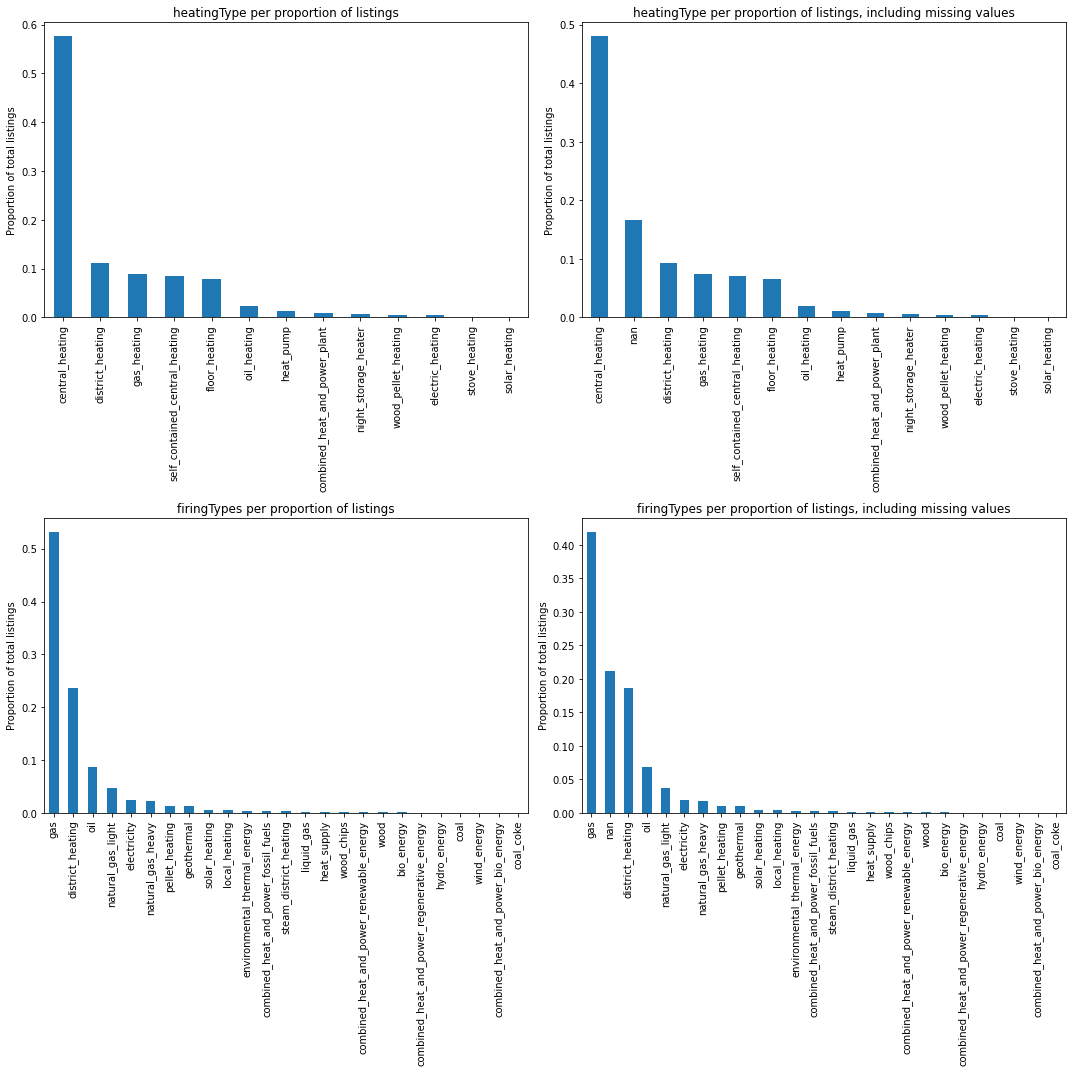

In [44]:
#View distribution of heatingType and firingTypes
fig, axs = plt.subplots(2, 2, figsize = (15, 15))
axs[0, 0].set_title('heatingType per proportion of listings')
rentals.heatingType.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0, 0])
axs[0, 0].set_ylabel('Proportion of total listings')
axs[0, 1].set_title('heatingType per proportion of listings, including missing values')
rentals.heatingType.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[0, 1])
axs[0, 1].set_ylabel('Proportion of total listings');
axs[1, 0].set_title('firingTypes per proportion of listings')
rentals.firingTypes.value_counts(normalize = True).plot(kind = 'bar', ax = axs[1, 0])
axs[1, 0].set_ylabel('Proportion of total listings')
axs[1, 1].set_title('firingTypes per proportion of listings, including missing values')
rentals.firingTypes.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1, 1])
axs[1, 1].set_ylabel('Proportion of total listings')
plt.tight_layout();

There are 15 categories for heatingType and 25 categories for firingTypes. These features provide a sense for how the property is heated. These features are not very well-defined. They both include data on the source of fuel and the type of heating system. For instance, heatingTypes includes central_heating (system) and gas (fuel), while firingTypes includes oil (fuel) and district heating (system). Since these features do not provide data that is mutually exclusive, the data quality is low. We will drop these features from our dataset.

#### 5.5.3.2 telekomTvOffer 

In [45]:
#Determine proportion of telekomTvOffer categories
rentals.telekomTvOffer.value_counts(dropna = False)

ONE_YEAR_FREE    226948
NaN               32424
NONE               4951
ON_DEMAND          3636
Name: telekomTvOffer, dtype: int64

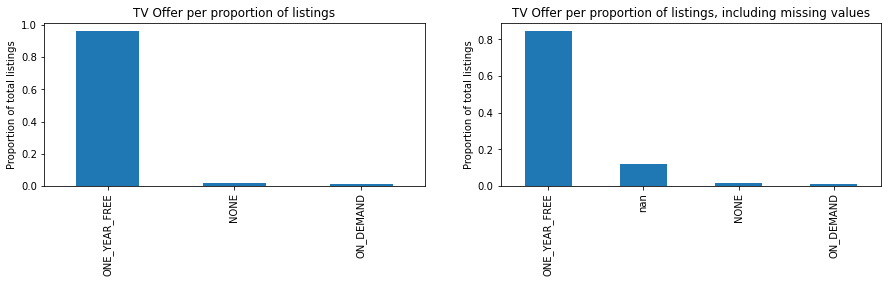

In [46]:
#View distribution of telekomTvOffer
fig, axs = plt.subplots(1, 2, figsize = (15, 3))
axs[0].set_title('TV Offer per proportion of listings')
rentals.telekomTvOffer.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('TV Offer per proportion of listings, including missing values')
rentals.telekomTvOffer.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

- We notice that telekomTvOffer has ONE_YEAR_FREE in 96% of existing cases. It is tempting to impute missing values with the most common category (i.e. ONE_YEAR_FREE), but we recognize that a TV offer is an incentive. Therefore, it is likely that if this data was not provided as part of the listing, there was no offer. We will therefore replace missing values with 'NONE'.

In [47]:
#Replace missing values of telekomTvOffer with 'NONE'
rentals.loc[rentals.telekomTvOffer.isnull(), 'telekomTvOffer'] = 'NONE'

In [48]:
#Verify no missing values for telekomTvOffer
rentals.telekomTvOffer.value_counts(normalize = True, dropna = False)

ONE_YEAR_FREE    0.846950
NONE             0.139480
ON_DEMAND        0.013569
Name: telekomTvOffer, dtype: float64

#### 5.5.3.3 condition 

In [49]:
#Review counts of condition categories
rentals.condition.value_counts(dropna = False)

NaN                                   68326
well_kept                             66393
refurbished                           26887
fully_renovated                       26296
mint_condition                        21866
first_time_use                        21795
modernized                            17185
first_time_use_after_refurbishment    15605
negotiable                             2232
need_of_renovation                     1370
ripe_for_demolition                       4
Name: condition, dtype: int64

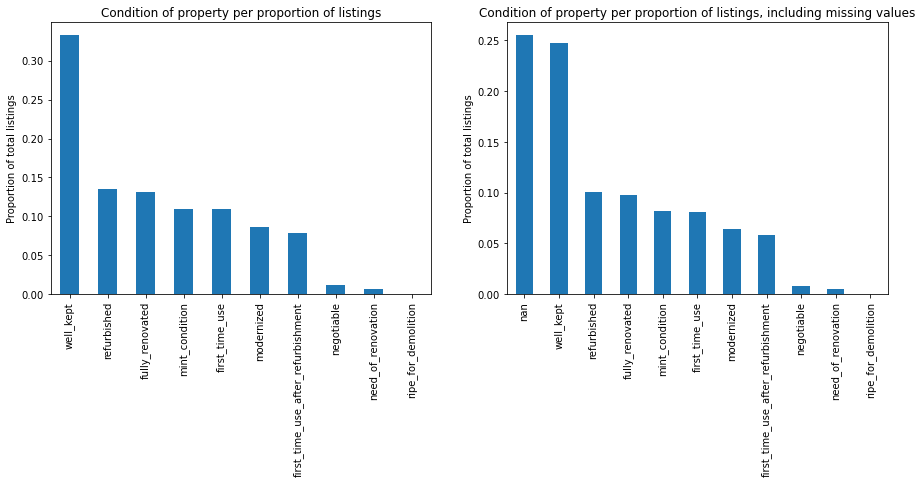

In [50]:
#View distribution of condition
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title('Condition of property per proportion of listings')
rentals.condition.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Condition of property per proportion of listings, including missing values')
rentals.condition.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

- condition provides details on the appearance of the property. We observe that over 25% of its values are missing. It is unlikely that we can fill missing values for 'condition' because it could be any of the 10 categories, although it is very likely that those properties that are first_time_use would be identified as such because they would command higher rent. We don't want to throw away such data. As such, we will record the missing values 'unknown'.

In [51]:
#Replace missing values with 'unknown'
rentals.loc[rentals.condition.isnull(), 'condition'] = 'unknown'

In [52]:
#Verify no missing values for condition
rentals.condition.value_counts(normalize = True, dropna = False)

unknown                               0.254987
well_kept                             0.247773
refurbished                           0.100340
fully_renovated                       0.098134
mint_condition                        0.081602
first_time_use                        0.081337
modernized                            0.064133
first_time_use_after_refurbishment    0.058237
negotiable                            0.008330
need_of_renovation                    0.005113
ripe_for_demolition                   0.000015
Name: condition, dtype: float64

#### 5.5.3.4 interiorQual  

In [53]:
#Review counts of interiorQual categories
rentals.interiorQual.value_counts(dropna = False)

NaN              112301
normal            81652
sophisticated     64455
luxury             7607
simple             1944
Name: interiorQual, dtype: int64

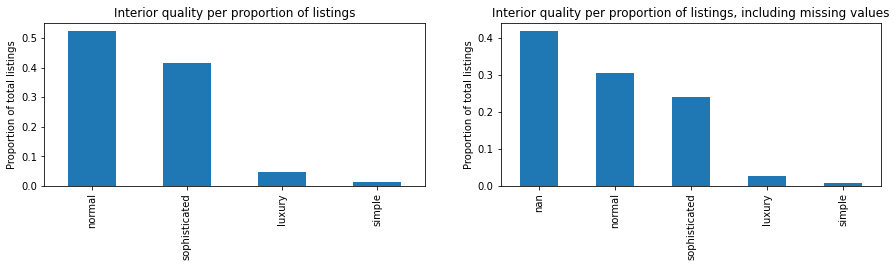

In [54]:
#View distribution of interiorQual
fig, axs = plt.subplots(1, 2, figsize = (15, 3))
axs[0].set_title('Interior quality per proportion of listings')
rentals.interiorQual.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Interior quality per proportion of listings, including missing values')
rentals.interiorQual.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

We observe that over 40% of listings do not have data on interiorQual. That said, we believe that those properties that are of the highest quality will command higher rent and would be identified (i.e. sophisticated and luxury). We will therefore, replace missing values with 'unknown'.

In [55]:
#Replace missing values with 'unknown'
rentals.loc[rentals.interiorQual.isnull(), 'interiorQual'] = 'unknown'
#Verify no missing values for interiorQual
rentals.interiorQual.value_counts(normalize = True, dropna = False)

unknown          0.419098
normal           0.304718
sophisticated    0.240541
luxury           0.028389
simple           0.007255
Name: interiorQual, dtype: float64

#### 5.5.3.5 petsAllowed 

In [56]:
#Check count of petsAllowed categories
rentals.petsAllowed.value_counts(dropna = False)

NaN           114157
negotiable     91688
no             51842
yes            10272
Name: petsAllowed, dtype: int64

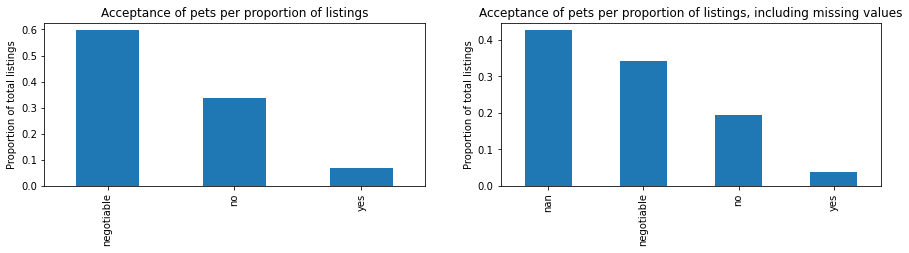

In [57]:
#View distribution of petsAllowed
fig, axs = plt.subplots(1, 2, figsize = (15, 3))
axs[0].set_title('Acceptance of pets per proportion of listings')
rentals.petsAllowed.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Acceptance of pets per proportion of listings, including missing values')
rentals.petsAllowed.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

We notice that over 40% of the values is missing. Furthermore, we suspect that whether or not a pet is allowed is unlikely to substantially affect rent. It is very likley that we drop this feature.

#### 5.5.3.7 typeOfFlat 

In [58]:
#Review counts of typeOfFlat categories
rentals.typeOfFlat.value_counts(dropna = False)

apartment              131056
NaN                     36500
roof_storey             34668
ground_floor            31447
other                    9488
maisonette               9298
raised_ground_floor      5611
penthouse                3547
terraced_flat            3377
half_basement            2011
loft                      956
Name: typeOfFlat, dtype: int64

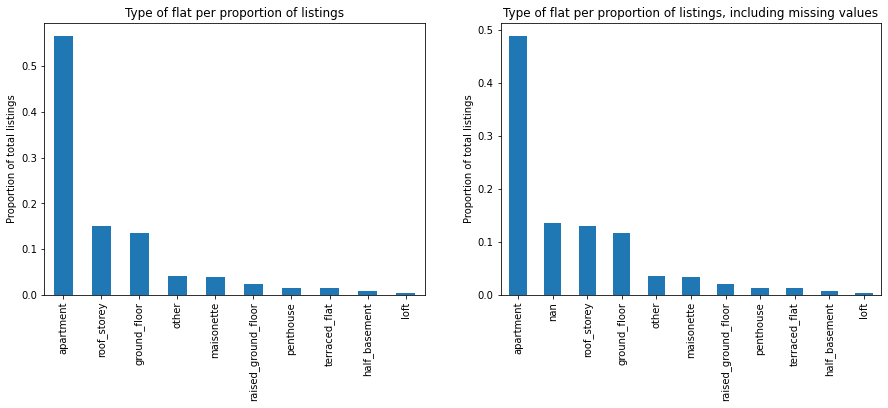

In [59]:
#View distribution of typeOfFlat
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title('Type of flat per proportion of listings')
rentals.typeOfFlat.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Type of flat per proportion of listings, including missing values')
rentals.typeOfFlat.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

Over 48% of the listings are apartments and about 12% of the values are missing. We suspect that some features are associated with a higher rent (e.g. penthouse). We replace missing values and values having 'other' with 'unknown'.

In [60]:
#Replace missing values with 'unknown'
rentals.loc[rentals.typeOfFlat.isnull() | (rentals.interiorQual == 'other'), 'typeOfFlat'] = 'unknown'
#Verify no missing or 'other' values for typeOfFlat
rentals.typeOfFlat.value_counts(normalize = True, dropna = False)

apartment              0.489090
unknown                0.136215
roof_storey            0.129378
ground_floor           0.117358
other                  0.035408
maisonette             0.034699
raised_ground_floor    0.020940
penthouse              0.013237
terraced_flat          0.012603
half_basement          0.007505
loft                   0.003568
Name: typeOfFlat, dtype: float64

#### 5.5.3.8 facilities & description 

facilities indicate the types of ammenities the unit has. description provides more details on the unit. These two features are text strings, whose analysis is outside the scope of the project. 

In [61]:
rentals[['facilities', 'description']].head()

,facilities,description
0,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,Die ebenerdig zu erreichende Erdgeschosswohnun...
1,NaN,Alles neu macht der Mai – so kann es auch für ...
2,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",Der Neubau entsteht im Herzen der Dresdner Neu...
3,NaN,Abseits von Lärm und Abgasen in Ihre neue Wohn...
4,Diese Wohnung wurde neu saniert und ist wie fo...,Es handelt sich hier um ein saniertes Mehrfami...


In [62]:
#Check unique values for facilities and description
rentals.facilities.nunique(), rentals.description.nunique()

(189526, 212621)

In [63]:
#Check proprotioin of missing values for facilities and description
rentals.facilities.isnull().mean(), rentals.description.isnull().mean()

(0.19691445333054683, 0.0734701950671558)

facilities and description are features with text data. Terms within the text may influence rent. As such, there is an opportunity to transform these features to a more useful format, although in doing so, we may increase the sparsity of the dataset.

#### 5.5.3.8 energyEfficiencyClass

In [64]:
rentals[['energyEfficiencyClass']].head()

,energyEfficiencyClass
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [65]:
#Find percentage of values per category
rentals.energyEfficiencyClass.value_counts(dropna = False, normalize = True).sort_index() * 100

A                  1.844312
A_PLUS             1.333413
B                  4.212585
C                  5.445982
D                  5.186241
E                  2.974709
F                  1.671151
G                  0.673237
H                  0.336992
NO_INFORMATION     5.257521
NaN               71.063857
Name: energyEfficiencyClass, dtype: float64

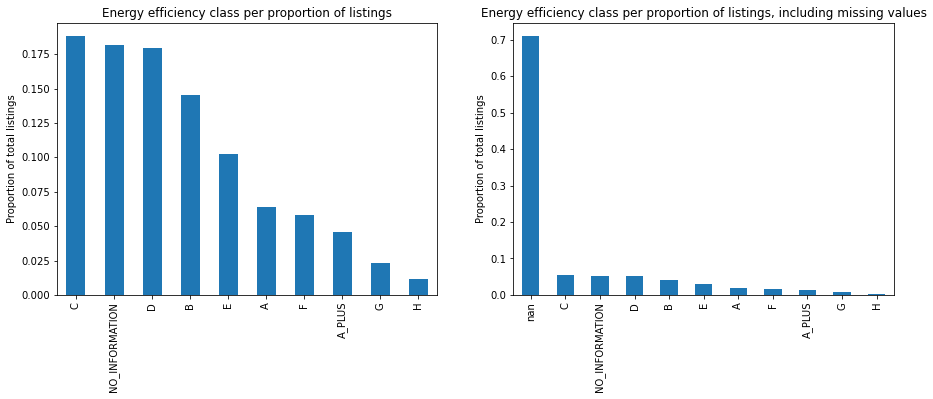

In [66]:
#View distribution of energyEfficiencyClass
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
axs[0].set_title('Energy efficiency class per proportion of listings')
rentals.energyEfficiencyClass.value_counts(normalize = True).plot(kind = 'bar', ax = axs[0])
axs[0].set_ylabel('Proportion of total listings')
axs[1].set_title('Energy efficiency class per proportion of listings, including missing values')
rentals.energyEfficiencyClass.value_counts(normalize = True, dropna = False).plot(kind = 'bar', ax = axs[1])
axs[1].set_ylabel('Proportion of total listings');

We note that over 70% of values are missing. It is likely that this information is not known by many landlords because a certification is required from a government agency. Energy certification for buildings is a relatively new requirement from the German government. Not providing this information does not necessarily mean that the building has a low effieciency class. It could just be the case that an assessment had not been done. We are unlikely to find a proper imputation method to account for lack of information, especially given how many samples do not have this information. We will therefore drop this column. 

## 5.6 Reviewing Numerical Features

In [67]:
#Select numeric features
numeric = ['int64', 'float64']
rentals.select_dtypes(numeric).head()

,serviceCharge,telekomHybridUploadSpeed,picturecount,pricetrend,telekomUploadSpeed,totalRent,scoutId,noParkSpaces,yearConstructedRange,baseRent,livingSpace,baseRentRange,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,livingSpaceRange,heatingCosts,electricityBasePrice,electricityKwhPrice
0,245.00,NaN,6,4.62,10.0,840.0,96107057,1.0,2.0,595.0,86.00,4,44269,4.0,181.4,1.0,3.0,4,4,NaN,NaN,NaN
1,134.00,NaN,8,3.47,10.0,NaN,111378734,2.0,1.0,800.0,89.00,5,67459,3.0,NaN,NaN,NaN,3,4,NaN,NaN,NaN
2,255.00,10.0,8,2.72,2.4,1300.0,113147523,1.0,9.0,965.0,83.80,6,1097,3.0,NaN,3.0,4.0,3,4,NaN,NaN,NaN
3,58.15,NaN,9,1.53,40.0,NaN,108890903,NaN,2.0,343.0,58.15,2,9599,3.0,86.0,3.0,NaN,3,2,87.23,NaN,NaN
4,138.00,NaN,19,2.46,NaN,903.0,114751222,NaN,1.0,765.0,84.97,5,28213,3.0,188.9,1.0,NaN,3,4,NaN,NaN,NaN


In [68]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [69]:
#Check statistics for numberic features
rentals.select_dtypes(numeric).describe().T

,count,mean,std,min,25%,50%,75%,max
serviceCharge,261085.00,151.22,308.75,0.00,95.00,135.00,190.00,146118.00
telekomHybridUploadSpeed,44906.00,10.00,0.00,10.00,10.00,10.00,10.00,10.00
picturecount,267959.00,9.79,6.40,0.00,6.00,9.00,13.00,121.00
pricetrend,266130.00,3.39,1.96,-12.33,2.00,3.39,4.57,14.92
telekomUploadSpeed,234797.00,28.80,16.34,1.00,10.00,40.00,40.00,100.00
totalRent,227573.00,901.53,33293.77,0.00,470.00,650.00,984.00,15751535.00
scoutId,267959.00,106954200.10,12516209.78,28871743.00,106680477.00,111153863.00,113767817.00,115711743.00
noParkSpaces,92756.00,1.33,8.37,0.00,1.00,1.00,1.00,2241.00
yearConstructedRange,211101.00,3.71,2.73,1.00,1.00,3.00,5.00,9.00
baseRent,267959.00,694.14,19568.44,0.00,338.00,490.00,799.00,9999999.00


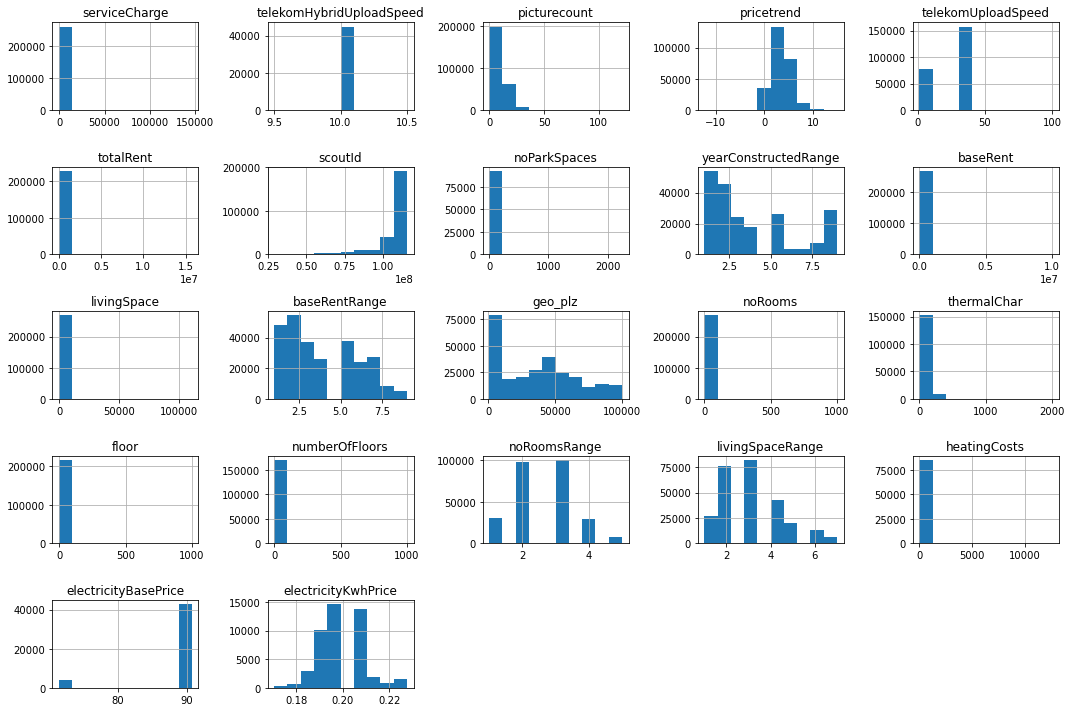

In [70]:
#Plot histograms of numeric features
rentals.select_dtypes(numeric).hist(figsize = (15, 10))
plt.tight_layout();

- The distributions of baseRent, floor, livingSpace, noRooms, numberOfFloors, serviceCharge, thermalChar and totalRent are highly skewed to the right.

### 5.6.1 scoutId and geo_plz 

We first note that scoutId and geo_plz should be objects even though they have numerical representation.
- scoutId is the identification number for the property
- geo_plz is the zip code for the property

In [71]:
#Convert scoutId and geo_plz to objects
rentals.scoutId = rentals.scoutId.astype('object')
rentals.geo_plz = rentals.geo_plz.astype('object')
rentals.dtypes['scoutId'], rentals.dtypes['geo_plz']

(dtype('O'), dtype('O'))

In [72]:
#Check number of categories
rentals.scoutId.nunique(), rentals.geo_plz.nunique()

(267959, 7634)

scoutId is the specific listing number. This information is useless and will be dropped.

### 5.6.3 Reviewing price/cost-related information <br>(baseRent, serviceCharge, heatingCost, totalRent)</br>

### Crossfield Validation of Price-related Features 

- Data owner noted that totalRent was the sum of baseRent, serviceCharge and heatingCosts. Let us review these features to determine which rows adhere to this formula

In [73]:
#Create new crossfield validation features and specify variable with price and crossfield validation features
rentals['crossfield_service'] = rentals.baseRent + rentals.serviceCharge
rentals['crossfield_heating'] = rentals.baseRent + rentals.heatingCosts
rentals['crossfield_all'] = rentals.baseRent + rentals.serviceCharge + rentals.heatingCosts
crossfields = ['baseRent','serviceCharge', 'heatingCosts','crossfield_service', \
               'crossfield_heating','crossfield_all', 'totalRent']
rentals[crossfields].sample(20)

,baseRent,serviceCharge,heatingCosts,crossfield_service,crossfield_heating,crossfield_all,totalRent
166466,750.00,80.00,150.00,830.00,900.00,980.00,980.00
116820,1193.00,237.00,0.00,1430.00,1193.00,1430.00,1430.00
148999,345.00,70.00,70.00,415.00,415.00,485.00,485.00
66867,293.19,37.32,165.00,330.51,458.19,495.51,495.51
168091,660.00,180.00,NaN,840.00,NaN,NaN,NaN
190483,1076.00,249.00,NaN,1325.00,NaN,NaN,1325.00
38968,980.00,200.00,NaN,1180.00,NaN,NaN,1180.00
74230,644.00,180.00,NaN,824.00,NaN,NaN,NaN
259382,450.00,80.00,NaN,530.00,NaN,NaN,530.00
256116,560.00,200.00,NaN,760.00,NaN,NaN,760.00


We observe that totalRent could be the sum of baseRent and serviceCharge; baseRent and heatingCosts; or baseRent, serviceCharge and heatingCosts. This implies that there is a lot of uncertainty with totalRent.

### baseRent

baseRent has a very long tail. A log transformation may shed some light on the overall shape of the distribution.

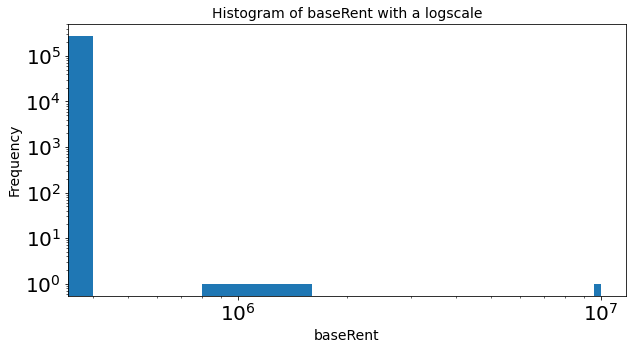

In [74]:
#Plot of baseRent
rentals.plot(y = 'baseRent', kind = 'hist', bins = 25, loglog = True, fontsize = 20, figsize = (10,5), legend = False)
plt.xlabel('baseRent', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of baseRent with a logscale', fontsize = 14);

The histogram shows a few values (less than 10) with very high baseRents. Let us review observation with rent over  €100,000.

In [75]:
rentals.loc[rentals.baseRent > 100_000, select]

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date
8406,29,Kastanienweg,Sankt_Leon_Rot,Rhein_Neckar,Baden_Württemberg,68789,1234567.00,1234567.00,4.00,76.00,2018-09-01
16731,70,Coppistraße,Gohlis_Mitte,Leipzig,Sachsen,4157,120000.00,NaN,3.00,65.72,2020-02-01
243713,15 a,Weg_zur_Platte,Bredeney,Essen,Nordrhein_Westfalen,45133,120000.00,NaN,3.50,14000.00,2019-05-01
260259,45,Zu_den_Wiesen,Güssefeld,Altmarkkreis_Salzwedel,Sachsen_Anhalt,39624,1000000.00,1000000.00,1.00,10.00,2019-05-01
264934,0815,Teststr.,Beckingen,Merzig_Wadern,Saarland,66666,9999999.00,NaN,1.00,1.00,2020-02-01


We note that the last two observations have livingSpace values that are small for the amount being paid for baseRent. The first row has a baseRent which is 1234567. This is likely to be inaccurate. The third observation has a baseRent that seem reasonable in light of the livingSpace, but not with the small number of rooms. We will remove all these observations from the dataset.

In [76]:
#Filter-out values of baseRent greater than 100_000
rentals = rentals[~(rentals.baseRent > 100_000)]

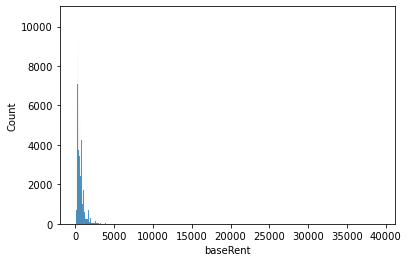

In [77]:
#Review histogram of baseRent
sns.histplot(data = rentals, x = 'baseRent');

We still observe a right-handed tail for baseRent. Let us view the distribution of listings greater than 5000 euros.

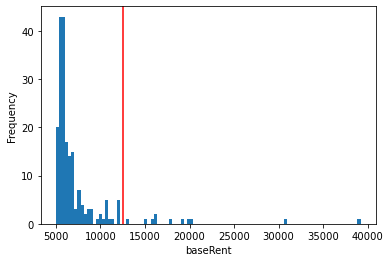

In [78]:
#Plot histogram of baseRent higher than 5000 euros
rentals.baseRent[rentals.baseRent > 5000].plot.hist(bins = 100)
plt.axvline(12500, color = 'red')
plt.xlabel('baseRent');

We observe values that there are not that many values over 12500 euros. We suspect that these may be incorrect values, but let us confirm.

In [79]:
rentals[rentals.baseRent > 12500]

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date,crossfield_service,crossfield_heating,crossfield_all
57237,Bayern,1550.00,NaN,ONE_YEAR_FREE,10.00,False,True,12,4.89,2.40,15000.00,2016-01-01,112740899,3.00,NaN,True,Bayern,False,9.00,13000.00,NaN,269.00,München,unknown,unknown,NaN,no_information,NaN,True,9,unknown,80538,6.00,NaN,NaN,NaN,5,False,7,München,Lehel,Die high-end-Wohnung befindet sich in einem te...,NaN,NaN,NaN,NaT,NaN,NaN,2019-10-01,14550.00,NaN,NaN
163402,Berlin,NaN,district_heating,ONE_YEAR_FREE,NaN,False,True,27,8.77,10.00,15000.00,2012-01-01,102693974,1.00,district_heating,True,Berlin,True,8.00,15000.00,13,456.00,Berlin,first_time_use,luxury,negotiable,Oberwallstra&szlig;e,Oberwallstraße,True,9,other,10117,4.00,NaN,NaN,5.00,4,False,7,Berlin,Mitte_Mitte,Das Townhouse wurde 2012 nach neusten technisc...,Das Wohn- und Esszimmer mit einer ca. 70 m2 gr...,NaN,NaN,2018-01-01,90.76,0.20,2018-09-01,NaN,NaN,NaN
170816,Hessen,1259.00,gas_heating,ON_DEMAND,NaN,False,True,11,5.21,2.40,20588.00,NaT,114421851,3.00,gas,False,Hessen,False,NaN,19329.00,42-46,601.85,Frankfurt_am_Main,first_time_use_after_refurbishment,luxury,negotiable,Hochstra&szlig;e,Hochstraße,True,9,penthouse,60322,6.00,137.00,7.00,7.00,5,False,7,Frankfurt_am_Main,Innenstadt,"Ausgestattet mit hochwertigem Eichen-Parkett, ...",- einmalige Möglichkeit!\n- Eiche-Parkett\n- b...,NaN,NO_INFORMATION,2019-01-01,NaN,NaN,2020-02-01,20588.00,NaN,NaN
176647,Bremen,78.00,central_heating,ONE_YEAR_FREE,NaN,False,False,2,4.62,10.00,449.90,1957-01-01,107354082,NaN,gas,False,Bremen,True,2.00,30990.00,3,47.67,Bremen,unknown,unknown,negotiable,H&ouml;xterstra&szlig;e,Höxterstraße,False,9,roof_storey,28277,3.00,192.40,2.00,2.00,3,False,2,Bremen,Kattenesch,In Kattenesch befinden sich 406 unserer Wohnun...,Die helle und gutgeschnittene Wohnung bietet I...,62.00,NO_INFORMATION,NaT,90.76,0.18,2018-09-01,31068.00,31052.00,31130.00
177289,Berlin,3800.00,central_heating,ONE_YEAR_FREE,NaN,False,True,35,8.55,10.00,19600.00,2017-01-01,109618469,2.00,district_heating,True,Berlin,True,9.00,15800.00,27,565.00,Berlin,unknown,luxury,negotiable,Oberwallstra&szlig;e,Oberwallstraße,True,9,unknown,10117,12.00,88.00,NaN,6.00,5,True,7,Berlin,Mitte_Mitte,Dieses eindrucksvolle Townhouse überzeugt auf ...,• Parkettfußboden mit Fischgrätverlegung \n• s...,NaN,C,2018-01-01,NaN,NaN,2019-05-01,19600.00,NaN,NaN
181618,Sachsen,165.00,central_heating,ONE_YEAR_FREE,NaN,False,False,11,1.41,40.00,NaN,NaT,84621450,NaN,NaN,False,Sachsen,False,NaN,39200.00,NaN,49.00,Dresden,mint_condition,sophisticated,NaN,no_information,NaN,True,9,roof_storey,1109,1.00,NaN,3.00,4.00,1,False,2,Dresden,Klotzsche,Die extravagante Wohnung befindet sich im Dach...,- Lift\r\n- Bad mit Wanne und Fenster (Oberlic...,NaN,NaN,NaT,NaN,NaN,2019-05-01,39365.00,NaN,NaN
190283,Berlin,6500.00,central_heating,ONE_YEAR_FREE,NaN,False,False,30,8.28,40.00,26500.00,2004-01-01,112710749,NaN,district_heating,True,Berlin,False,6.00,20000.00,4,566.00,Berlin,mint_condition,unknown,NaN,Potsdamer Platz,Potsdamer_Platz,True,9,apartment,10785,10.00,77.20,17.00,17.00,5,False,7,Berlin,Tiergarten_Tiergarten,"Erleben Sie Wohnen auf höchstem Niveau, direkt...","\r- Besonderheiten: Alarmanlage, Klimaanlage",NaN,NaN,NaT,NaN,NaN,2019-10-01,26500.00,NaN,NaN
213625,Bayern,140.00,central_heating,ONE_YEAR_FREE,NaN,False,True,15,6.49,40.00,2390.00,1892-01-01,107309166,NaN,district_heating,False,Bayern,True,1.00,20100.00,23,110.00,München,well_kept,

After reviewing the data, we notice that the number of rooms for most of these properties are greater than one or that they are considered to by luxury or in mint_condition. As such, we don't have much evidence to remove these listings. We will leave them as is.

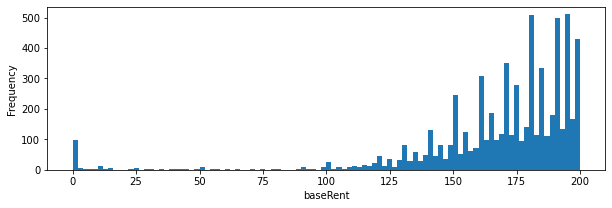

In [80]:
#Reviewing baseRent less than 200 euros
plt.figure(figsize = (10, 3))
rentals.baseRent[rentals.baseRent < 200].plot.hist(bins = 100)
plt.xlabel('baseRent');

We notice that the count of values of baseRent start to taper off below 100 euros. Let's review these values in more detail.

In [81]:
#View baseRent less than 100 euros
rentals.loc[rentals.baseRent < 100, ['baseRent','heatingCosts', 'serviceCharge', 'totalRent', 'interiorQual', 'condition']].head(20)

,baseRent,heatingCosts,serviceCharge,totalRent,interiorQual,condition
201,0.00,NaN,90.00,NaN,normal,fully_renovated
1377,0.00,NaN,NaN,700.00,normal,fully_renovated
2045,0.00,NaN,154.00,731.50,unknown,well_kept
6601,35.00,0.00,0.00,35.00,normal,well_kept
6911,0.00,NaN,NaN,370.00,unknown,unknown
8987,90.00,NaN,30.00,NaN,unknown,well_kept
9860,3.00,92.00,92.00,460.00,unknown,refurbished
11130,0.00,NaN,NaN,NaN,unknown,unknown
11922,25.00,NaN,NaN,25.00,unknown,mint_condition
12614,25.00,NaN,NaN,NaN,sophisticated,well_kept


We notice that in some cases a totalRent is given instead of a baseRent. We also observe that these case typically don't have serviceCharge or heatingCosts. It could therefore be the case that this was a mistake, or truly, the totalRent covers all expenses. Regardless, we can estimate baseRent with the totalRent. 

In [82]:
#Replace baseRent values with totalRent value when baseRent is 0
rentals.baseRent = rentals.baseRent.where(rentals.baseRent != 0, rentals.totalRent)
(rentals.baseRent == 0).sum()

7

We have replaced values of baseRent that were 0 with totalRent. However, we observe that there are still some values of baseRent that are 0, implying that totalRent was also 0 or nan. Let's confirm.

In [83]:
#Check listings with 0 baseRent
rentals.loc[rentals.baseRent == 0, ['baseRent', 'totalRent']]

,baseRent,totalRent
35630,0.00,0.00
69577,0.00,0.00
79919,0.00,0.00
93073,0.00,0.00
121653,0.00,0.00
176365,0.00,0.00
216231,0.00,0.00


Listings with 0 for baseRent and totalRent cannot be modelled. Let us remove these listings.

In [84]:
#Removing listings with baseRent that is 0
rentals = rentals[~(rentals.baseRent == 0)]

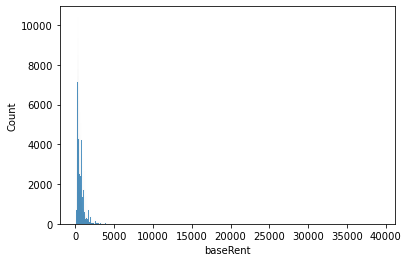

In [85]:
#Review histogram of baseRent
sns.histplot(data = rentals, x = 'baseRent');

### serviceCharge

In [86]:
rentals.serviceCharge.describe()

count   261079.00
mean       151.13
std        304.90
min          0.00
25%         95.00
50%        135.00
75%        190.00
max     146118.00
Name: serviceCharge, dtype: float64

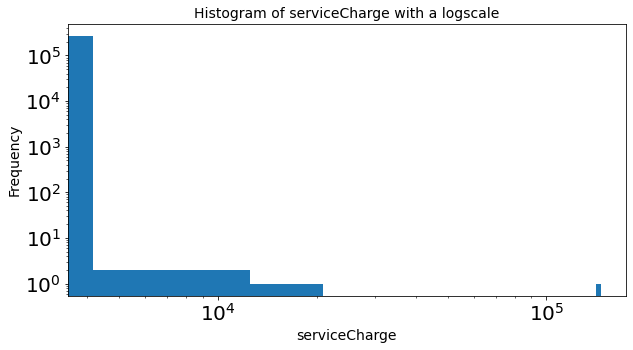

In [87]:
#Plot of serviceCharge
rentals.plot(y = 'serviceCharge', kind = 'hist', bins = 35, loglog = True, fontsize = 20, figsize = (10,5), legend = False)
plt.xlabel('serviceCharge', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of serviceCharge with a logscale', fontsize = 14);

Let's view serviceCharge values that are over €5000.

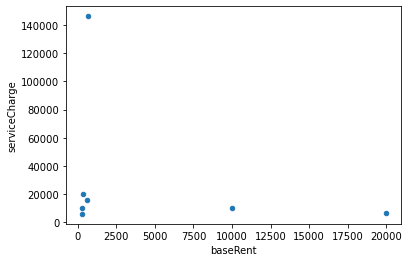

In [88]:
#Check the relationship between serviceCharge and baseRent
rentals.loc[rentals.serviceCharge > 5000, select + ['serviceCharge']].plot(y = 'serviceCharge', x = 'baseRent', kind = 'scatter');

We observe that there are some units with high serviceCharges and low baseRents. Let us see these observations.

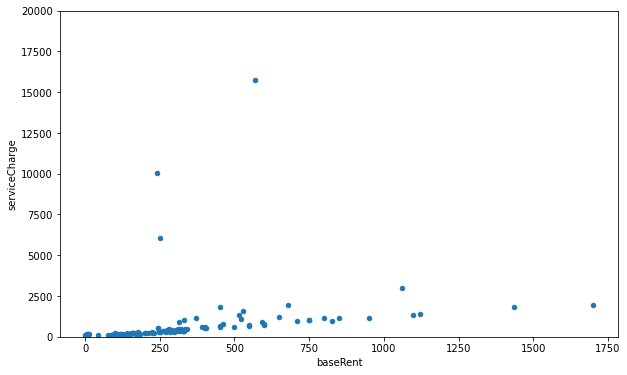

In [89]:
rentals.loc[(rentals.serviceCharge > rentals.baseRent), ['baseRent', 'serviceCharge', 'totalRent']]\
.plot(x = 'baseRent', figsize = (10, 6), y = 'serviceCharge', kind = 'scatter')
plt.ylim([0, 20000]);

We observe a general upward trend between serviceCharge and baseRent for instances where serviceCharge is greater than baseRent. However, there are outliers exist where serviceCharge is above 3000 euros. Let us view these listings.

In [90]:
rentals.loc[(rentals.serviceCharge > rentals.baseRent) & (rentals.serviceCharge > 3000), ['baseRent', 'serviceCharge', 'totalRent', 'noRooms']]

,baseRent,serviceCharge,totalRent,noRooms
25687,648.29,146118.00,794.29,3.00
144897,346.08,20392.00,530.00,2.00
153825,567.00,15750.00,732.00,2.00
178325,240.90,10038.00,341.28,1.00
251364,251.57,6045.00,6343.07,2.00


In [91]:
#Remove listings
rentals = rentals[~((rentals.serviceCharge > rentals.baseRent) & (rentals.serviceCharge > 3000))]

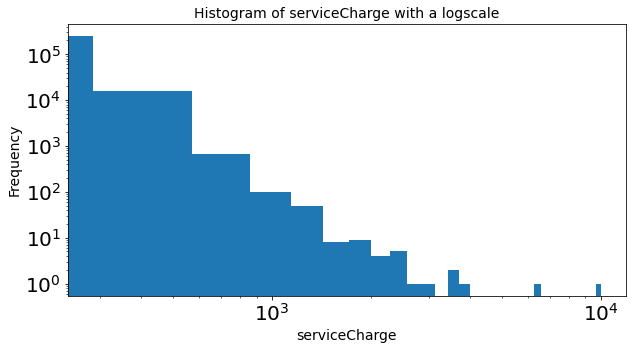

In [92]:
#Plot of serviceCharge
rentals.plot(y = 'serviceCharge', kind = 'hist', bins = 35, loglog = True, fontsize = 20, figsize = (10,5), legend = False)
plt.xlabel('serviceCharge', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of serviceCharge with a logscale', fontsize = 14);

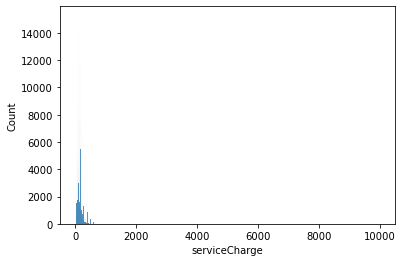

In [93]:
#Review histogram of serviceCharge
sns.histplot(data = rentals, x = 'serviceCharge');

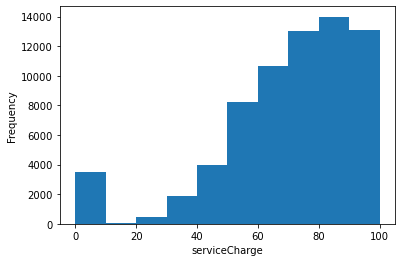

In [94]:
#Review low range of serviceCharge
rentals.serviceCharge[(rentals.serviceCharge < 100)].plot.hist()
plt.xlabel('serviceCharge');

We notice serviceCharge values typically rise from 20. A large number of servicecharge values are 0. Let's take a look.

In [95]:
#Check values for serviceCharge less than 0
rentals.loc[rentals.serviceCharge == 0,  ['baseRent', 'serviceCharge', 'totalRent', 'noRooms']].sample(10)

,baseRent,serviceCharge,totalRent,noRooms
98169,705.00,0.00,705.00,2.00
248460,850.00,0.00,850.00,1.00
78520,1310.00,0.00,1310.00,1.50
129320,3600.00,0.00,3600.00,3.50
188025,1190.00,0.00,1190.00,1.00
18453,1850.00,0.00,1850.00,3.00
150704,1600.00,0.00,1600.00,2.00
240964,1390.00,0.00,1390.00,2.00
110976,1590.00,0.00,1590.00,2.00
65794,1090.00,0.00,1090.00,3.00


We observe that many of these values may be given a 0 value for serviceCharge data that is unknown. We will replace these values with nan.

In [96]:
#Convert serviceCharge data that is zero to np.nan
rentals.loc[rentals.serviceCharge == 0, 'serviceCharge'] = np.nan
rentals.serviceCharge.isnull().sum()

10291

Together with the original nan values, we have over 10,000 serviceCharge costs that are unknown. We can estimate these values when we pre-process the data before modelling. It is likley that we impute a median value for this feature.

### heatingCosts

In [97]:
rentals.heatingCosts.describe()

count   85223.00
mean       77.00
std       147.96
min         0.00
25%        54.00
50%        70.00
75%        90.00
max     12613.00
Name: heatingCosts, dtype: float64

In [98]:
#Proportion of heatingCosts values that are missing
rentals.heatingCosts.isnull().mean()

0.6819348963581671

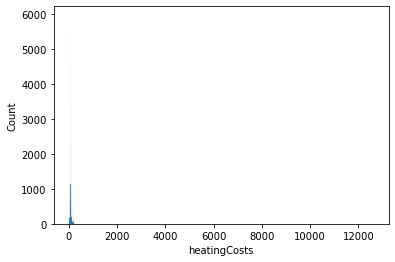

In [99]:
#Plot of heatingCosts
sns.histplot(data = rentals, x = 'heatingCosts');

We observe a very long tail for heatingCosts. We also observe that over 65% of the value of heatingCost is missing. There is no other feature that can be used to estimate heatingCosts. Any impution of this feature may improperly bias the data. We are therefore likley to drop this feature.

### totalRent

In [100]:
rentals.totalRent.describe()

count     227559.00
mean         891.72
std        33128.06
min            0.00
25%          470.00
50%          650.00
75%          984.00
max     15751535.00
Name: totalRent, dtype: float64

We have a very high value for totalRent (i.e.over 15 million euros). This is likely an outlier. Let us review totalRent values above the 75th percentile and totalRent values 10 times that of the baseRent.

In [101]:
rentals.loc[(rentals.totalRent > rentals.totalRent.quantile(0.75)) & \
            (rentals.totalRent > (10 * rentals.baseRent)),  ['baseRent', 'totalRent', 'noRooms']].\
sort_values(by = 'totalRent', ascending = False)

,baseRent,totalRent,noRooms
239533,1325.00,15751535.00,3.00
109047,950.00,1150900.00,5.00
79903,350.00,485350.00,3.50
23490,820.00,108000.00,2.50
197378,487.51,64651.00,3.00
16832,460.29,63204.00,2.00
97927,427.70,51570.00,1.00
240954,266.00,37600.00,2.00
50706,184.00,19519.00,1.00
209250,1050.00,13500.00,2.00


We can confirm that most of these values are outliers. We will replace the totalRent values with np.nan to conserve the baseRent value

In [102]:
rentals.loc[(rentals.totalRent > rentals.totalRent.quantile(0.75)) & \
            (rentals.totalRent > (10 * rentals.baseRent)), 'totalRent'] = np.nan

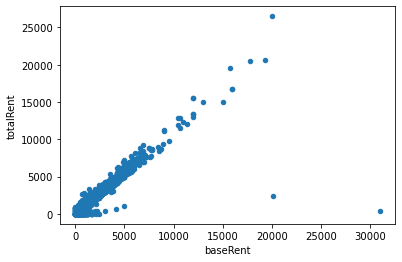

In [103]:
#Plot totalRent and baseRent
rentals.plot(x = 'baseRent', y = 'totalRent', kind = 'scatter');

We observe a linear relationship between totalRent and baseRent. 

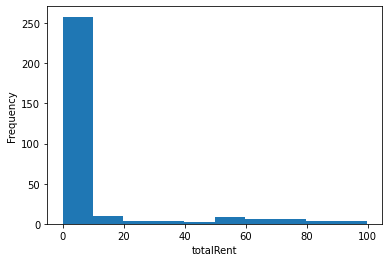

In [104]:
#Review low range of totalRent
rentals.totalRent[(rentals.totalRent < 100)].plot.hist()
plt.xlabel('totalRent');

We observe a few values of totalRent that are 0. It is likely the case that this information was not provided. Let us confirm with our crossvalidation and price/cost-related values.

In [105]:
rentals.loc[rentals.totalRent == 0, \
            ['baseRent','heatingCosts', 'serviceCharge', 'crossfield_service','crossfield_heating', 'crossfield_all','totalRent']].sample(10)

,baseRent,heatingCosts,serviceCharge,crossfield_service,crossfield_heating,crossfield_all,totalRent
8914,290.00,NaN,85.00,375.00,NaN,NaN,0.00
140404,220.50,NaN,75.00,295.50,NaN,NaN,0.00
65598,415.00,NaN,207.00,622.00,NaN,NaN,0.00
10195,242.05,NaN,140.00,382.05,NaN,NaN,0.00
36901,220.00,NaN,70.00,290.00,NaN,NaN,0.00
200778,320.00,NaN,150.00,470.00,NaN,NaN,0.00
232254,475.00,80.00,100.00,575.00,555.00,655.00,0.00
113850,427.00,NaN,105.00,532.00,NaN,NaN,0.00
203381,690.00,100.00,150.00,840.00,790.00,940.00,0.00
32005,380.00,NaN,180.00,560.00,NaN,NaN,0.00


We can now see that totalRent was not provided in many of these cases. 

In [106]:
#Number of missing values
rentals.totalRent.isnull().sum()

40400

totalRent has 40,000 of its values missing, has null values, and does not always include the values for all expenses. totalRent is therefore a feature that offers inconsistent and low quality data. baseRent, on-the-other-hand is not an aggregate feature, so does not suffer from the issues that totalRent suffers from. Furtherore, from a business perspective, landlords understand that expenses vary from property to property depending on a variety of conditions. Heating costs and service charges typically vary with usage. As such, landlords are more interested in baseRent than totalRent. For these reasons, we will develop a model to predict baseRent and drop totalRent from the dataset.

### Review Other Numeric Features
#### 5.6.4 picturecount 

In [107]:
#Check proportion of missing values
rentals.picturecount.isnull().mean()

0.0

- No values are missing. picturecount indicates how many pictures were loaded to the listing. Min of 0 and max of 121 makes sense. 


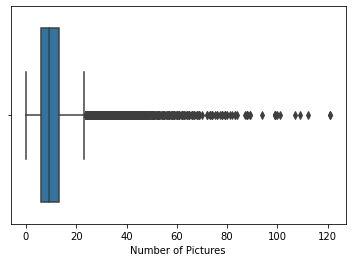

In [108]:
_= sns.boxplot(x = 'picturecount', data = rentals)
_= plt.xlabel('Number of Pictures')

We do not believe that the number of pictures affects baseRent. We are likely to drop this feature during modelling.

### telekomHbridUploadSpeed

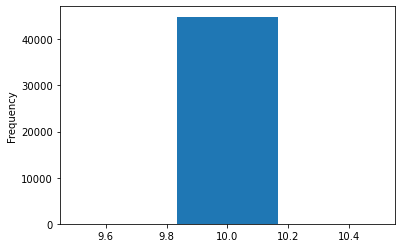

In [109]:
#telekomHbridUploadSpeed plt
rentals.plot(y = 'telekomHybridUploadSpeed', kind = 'hist', bins = 3, legend = False);

In [110]:
#Determine how many unique values for the feature
rentals.telekomHybridUploadSpeed.value_counts(normalize = True, dropna = False)

NaN     0.83
10.00   0.17
Name: telekomHybridUploadSpeed, dtype: float64

We note that telekomHybridUploadSpeed has only one value (10) and over 83% of its values are missing. This feature therefore does not provide any new information from observation to observation. We will drop this feature.

#### 5.6.5 pricetrend 

- pricetrend is a parameter calculated by immoscout. Calculation or metric was not provided, however, it likely indicates the percentage change in price for that apartment or similar apartments in the area. Observed that ~ 0.7% of its values are missing. Has a min value of -12 and max value of 14.9. Range seems reasonable at first glance. We are likely to drop this feature because we are not sure how the values are generated.

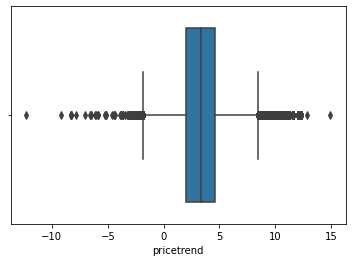

In [111]:
_= sns.boxplot(x = 'pricetrend', data = rentals)
_= plt.xlabel('pricetrend')

#### 5.6.6 telekomUploadSpeed 

- telekomUploadSpeed indicates internet upload speed. Determined that 12.4% of its values are missing. Unit not provided, but is typically measured in Mbps. Has seven values, with min speed of 1 and max speed of 100. Range seems reasonable at first glance. 


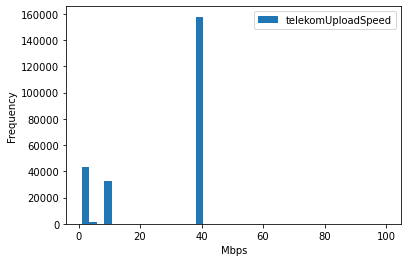

In [112]:
rentals.plot(y = 'telekomUploadSpeed', kind = 'hist', bins = 40)
plt.xlabel('Mbps');

In [113]:
rentals.telekomUploadSpeed.value_counts(dropna = False,normalize = True)

40.00    0.59
2.40     0.16
NaN      0.12
10.00    0.12
5.00     0.00
1.00     0.00
100.00   0.00
4.00     0.00
Name: telekomUploadSpeed, dtype: float64

In [114]:
rentals.telekomUploadSpeed.describe()

count   234785.00
mean        28.80
std         16.34
min          1.00
25%         10.00
50%         40.00
75%         40.00
max        100.00
Name: telekomUploadSpeed, dtype: float64

In [115]:
rentals.telekomUploadSpeed.median()

40.0

telekomUploadSpeed are standard rates offered by providers. We will impute missing values with median.

### noParkSpaces

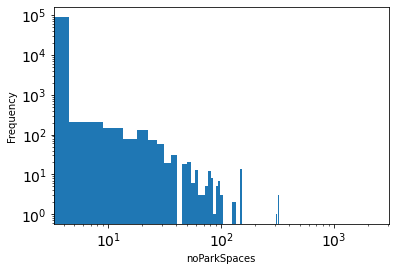

In [116]:
rentals.plot(y = 'noParkSpaces', kind = 'hist', bins = 500, loglog = True, legend = False, fontsize = 14)
plt.xlabel('noParkSpaces');

We note that there are a lot of units have more than 5 parking spaces. It is not clear what the noParkSpaces feature means. It could mean the number of parking spaces per unit or for the entire apartment complex. It may mean something else, altogether. For there to be so many observations with a high number of parking spaces suggests a systemic issues. 

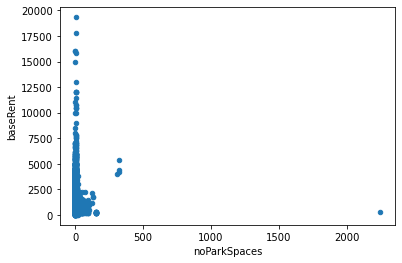

In [117]:
rentals.plot(x = 'noParkSpaces', y = 'baseRent', kind = 'scatter');

In [118]:
rentals.noParkSpaces.describe()

count   92752.00
mean        1.33
std         8.37
min         0.00
25%         1.00
50%         1.00
75%         1.00
max      2241.00
Name: noParkSpaces, dtype: float64

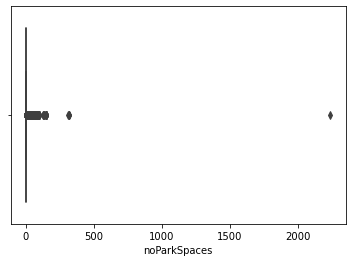

In [119]:
sns.boxplot(data = rentals, x = 'noParkSpaces');

We also observe that noParkSpaces only has 92,460 observations. This means that over 60% of the observations do not have this value. We note that the 25%, 50% and 75% percentiles have a value of 1. The mean is also close to 1. It does not appear that there isn't much variation in this feature, aside for one triggered by the high-end outliers. We will therefore drop this feature.

#### 5.6.7 livingSpace 

- livingSpace indicates living space in sqm. Min value of 0 and max value of 110,000 sqm, likely outliers.


In [120]:
rentals.livingSpace.describe()

count   267942.00
mean        74.32
std        253.76
min          0.00
25%         54.00
50%         67.34
75%         87.00
max     111111.00
Name: livingSpace, dtype: float64

A minimum value of 0 for living space does not make sense, and a maximum value of 111,111 m^2 is too high. The size of a european standard parking space is about 12 m^2 and that for a standard U.S parking space is about 17 m^2. So living spaces that are less than 17 m^2 are too small. If however, we are to assume that some interpreted livingSpace to mean the size of a room, we can set our minimum are at 7.5 sqm. Similarly, a football field has an area of about 11,000 m^2. Any units with values above this should be very expensive. Also, a Sotheby's advert for a 6 bedroom property had an area of 514 sqm. This means that we expect that the bigger the livingSpace the more the number of rooms. Also a  Let us take at the log distribution of this feature.

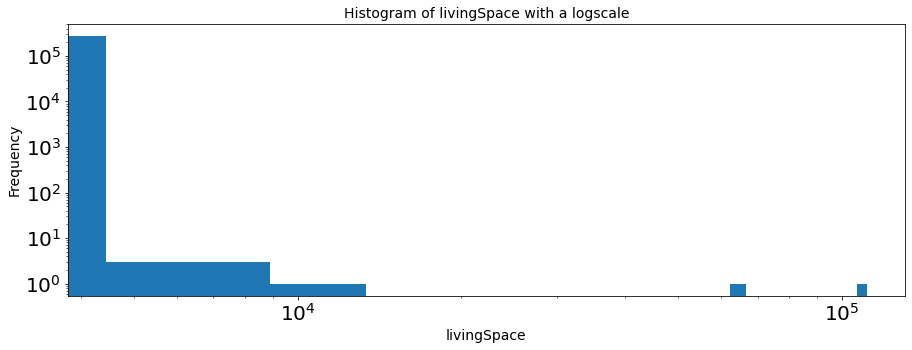

In [121]:
#Plot of livingSpace
rentals.plot(y = 'livingSpace', kind = 'hist', bins = 25, loglog = True, fontsize = 20, figsize = (15,5), legend = False)
plt.xlabel('livingSpace', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('Histogram of livingSpace with a logscale', fontsize = 14);

In [122]:
#Count units with small areas
(rentals.livingSpace < 7.5).sum()

100

There seems to be many units with small areas. We would expect their rents to be very low. Let's view how the size and rent of these units relate to each other.

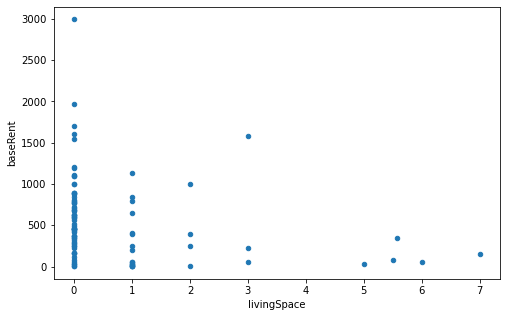

In [123]:
#Plot baseRent versus livingSpace for units with livingSpace less than 20
rentals[rentals.livingSpace < 7.5].plot.scatter(x = 'livingSpace', y = 'baseRent', figsize = (8, 5));

We note that some units with a livingSpace of 0 have high rents, which does not make sense. Let's see some of these units. 

In [124]:
#View livingSpace equal to 0
rentals.loc[rentals.livingSpace < 7.5, select].head()

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date
3444,18,Ellerbreite,Zoberberg,Dessau_Roßlau,Sachsen_Anhalt,6847,620.00,890.00,5.00,0.00,2019-10-01
5206,41,Delbrückstraße,Neukölln_Neukölln,Berlin,Berlin,12051,1584.80,1970.80,99.50,3.00,2019-10-01
6601,NaN,NaN,Merseburg,Saalekreis,Sachsen_Anhalt,6217,35.00,35.00,1.00,0.00,2019-05-01
7775,49,Alte_Poststraße,Kleinostheim,Aschaffenburg,Bayern,63801,1130.00,1280.00,3.00,1.00,2018-09-01
9343,NaN,NaN,Paderborn,Paderborn,Nordrhein_Westfalen,33098,795.00,795.00,1.50,1.00,2020-02-01


We can go into each observation and determine their proper treatment, but there are just over 100 units with this problem. We will remove these observations from our dataset.

In [125]:
#Remove units with area less than 7.5 sqm
rentals = rentals[~(rentals.livingSpace < 7.5)]

In [126]:
#Count of units with livingSpace greater than 400 sqm
(rentals.livingSpace > 400).sum()

55

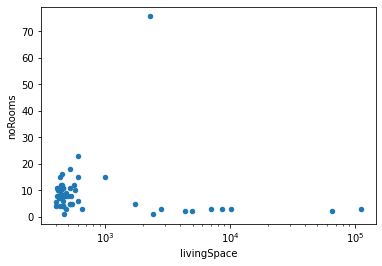

In [127]:
#Plot of livingSpace versus number of rooms for units over 400 sqm
rentals[rentals.livingSpace > 400].plot.scatter(x = 'livingSpace', y = 'noRooms', logx = True);

We note that there is one unit that has a very high room count and livingSpace. Other than this unit, most units fall below 30 rooms. We can further zoom in to the plot to see the dispersion of points less when noRooms is less than 30.

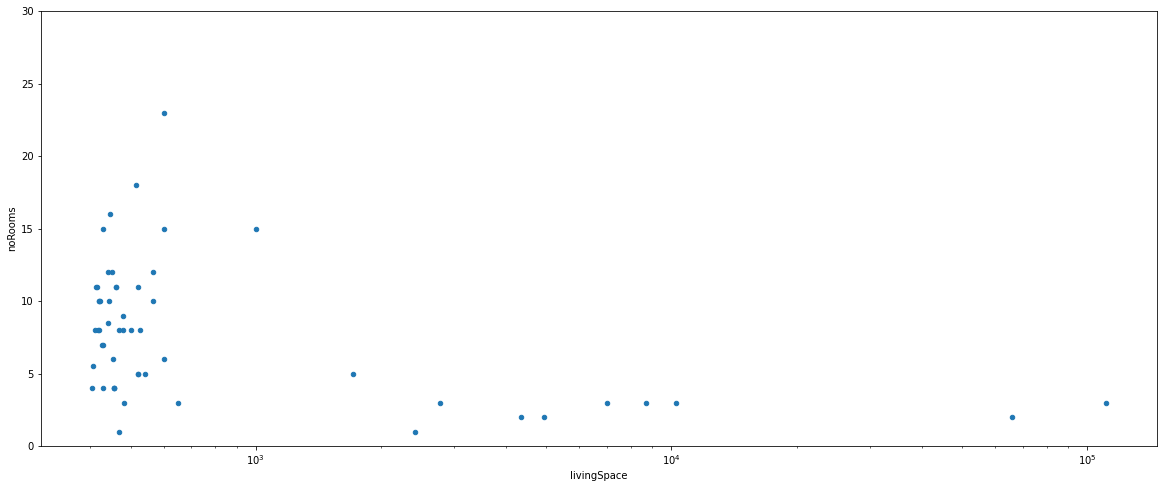

In [128]:
#View noRooms versus livingSpace for noRooms less than 30
rentals[rentals.livingSpace > 400].plot.scatter(x = 'livingSpace', y = 'noRooms', logx = True, figsize = (20, 8))
plt.ylim([0, 30]);

We notice that many of the units with livingSpace over 1000 sqm have noRooms less than 5. We would would expect them to be more. We will remove these from the dataset.

In [129]:
#Remove rentals with livingSpace greater than 1000
rentals = rentals[~(rentals.livingSpace > 1000)]

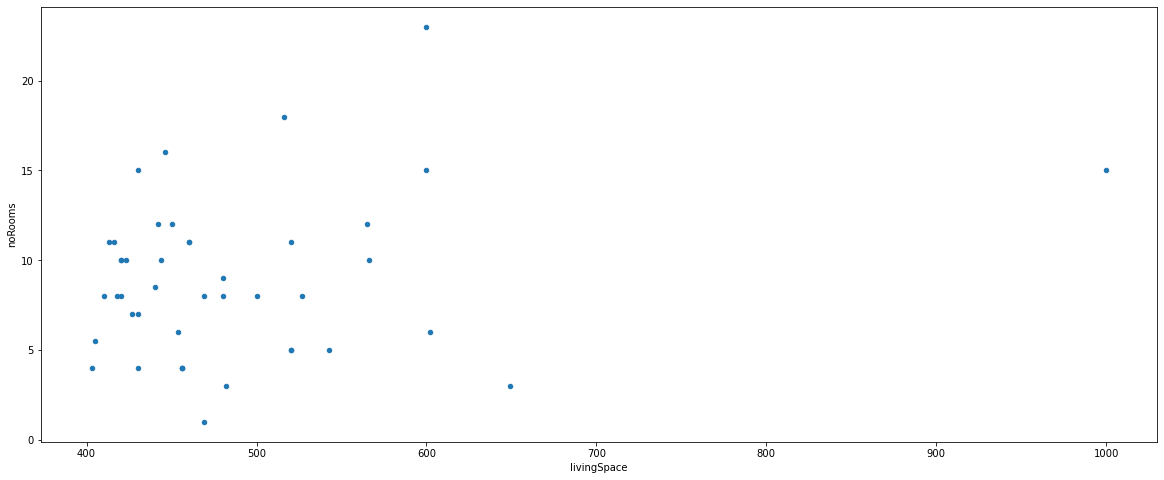

In [130]:
#View noRooms versus livingSpace for noRooms less than 30
rentals[rentals.livingSpace > 400].plot.scatter(x = 'livingSpace', y = 'noRooms', figsize = (20, 8));

There seems to be a general upward trend for livingSpace and noRooms. We will leave it as is. 

#### 5.6.8 noRooms 

- noRooms indicates number of rooms in apartment. Min value of 1. Max value of 999, likely an outlier. 

In [131]:
#View summary statistics for noRooms
rentals.noRooms.describe()

count   267831.00
mean         2.64
std          2.62
min          1.00
25%          2.00
50%          3.00
75%          3.00
max        999.99
Name: noRooms, dtype: float64

We notice a huge gap between the max number of rooms and the number of rooms at the 75th percentile. Let' see the histogram of this feature.

In [132]:
def histogram(df, feature, bin_count = 25, log = True, figsize = (15,5)):
    df.plot(y = feature, kind = 'hist', bins = bin_count, loglog = log, fontsize = 20, figsize = figsize, legend = False)
    plt.xlabel(feature, fontsize = 14)
    plt.ylabel('Frequency', fontsize = 14)
    plt.title(f'Histogram of {feature} with a logscale', fontsize = 14);
    

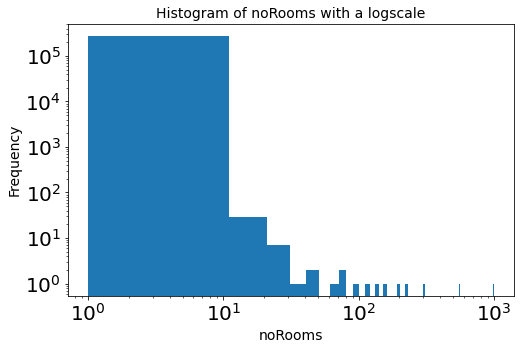

In [133]:
#View histogram of noRooms
histogram(rentals, 'noRooms', bin_count = 100, figsize = (8,5))

We note that there are units that have over 10 rooms and even up to 1000 rooms. Let us examine those units that have over 5 rooms. Typically, you expect that as the number of rooms increase, the livingSpace increases.

In [134]:
#Count units with over 10 rooms
(rentals.noRooms > 5).sum()

2320

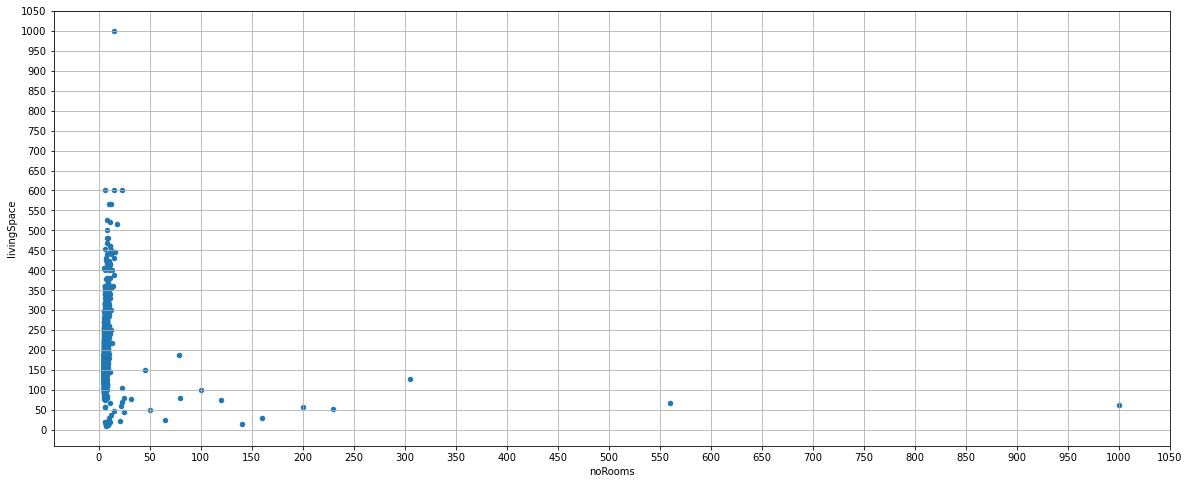

In [135]:
#Plot noRooms against baseRent to see how they relate.
rentals[rentals.noRooms > 5].plot.scatter(x = 'noRooms', y = 'livingSpace', figsize = (20, 8))
plt.yticks(np.arange(0, 1100, step= 50))
plt.xticks(np.arange(0, 1100, step= 50))
plt.grid();

We note that after 50 rooms there is no trend of livingSpace increasing with increasing number of rooms. Let's examine the units having more than 50 rooms

In [136]:
rentals.loc[rentals.noRooms > 50, select]

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date
17897,NaN,NaN,Iserlohn,Märkischer,Nordrhein_Westfalen,58638,307.00,451.50,200.00,57.00,2019-05-01
18961,8 + 9,Dreyerstraße,Calenberger_Neustadt,Hannover,Niedersachsen,30169,395.00,395.00,140.00,14.00,2019-10-01
36872,29,Sülmerstraße,Heilbronner_Kernstadt,Heilbronn,Baden_Württemberg,74072,1100.00,NaN,305.00,128.00,2019-10-01
98055,2,Ostring,Sörup,Schleswig_Flensburg,Schleswig_Holstein,24966,320.00,480.00,80.00,80.00,2020-02-01
103615,32,Erich-Mühsam-Str.,Kaßberg,Chemnitz,Sachsen,9112,282.00,NaN,999.99,61.17,2019-05-01
120251,23,Großer_Bruch,Clausthal_Zellerfeld,Goslar,Niedersachsen,38678,220.00,280.00,65.00,24.00,2020-02-01
134862,15,Auf_m_Winkel,Radevormwald,Oberbergischer,Nordrhein_Westfalen,42477,330.00,445.00,230.00,53.00,2019-10-01
174132,NaN,NaN,Waldheim,Mittelsachsen,Sachsen,4736,250.00,NaN,160.00,30.00,2018-09-01
185115,1,Buchener_Str.,Bad_Mergentheim,Main_Tauber,Baden_Württemberg,97980,450.00,560.00,560.00,67.00,2019-10-01
205003,16,Bahnhofstr.,Neu_Wulmstorf,Harburg,Niedersachsen,21629,700.00,900.00,100.00,100.00,2019-10-01


We note that the rents paid for these units are not so high as require a high number of rooms. These errors also appear to be random. We will remove these entries.

In [137]:
rentals = rentals.loc[~(rentals.noRooms > 50)]

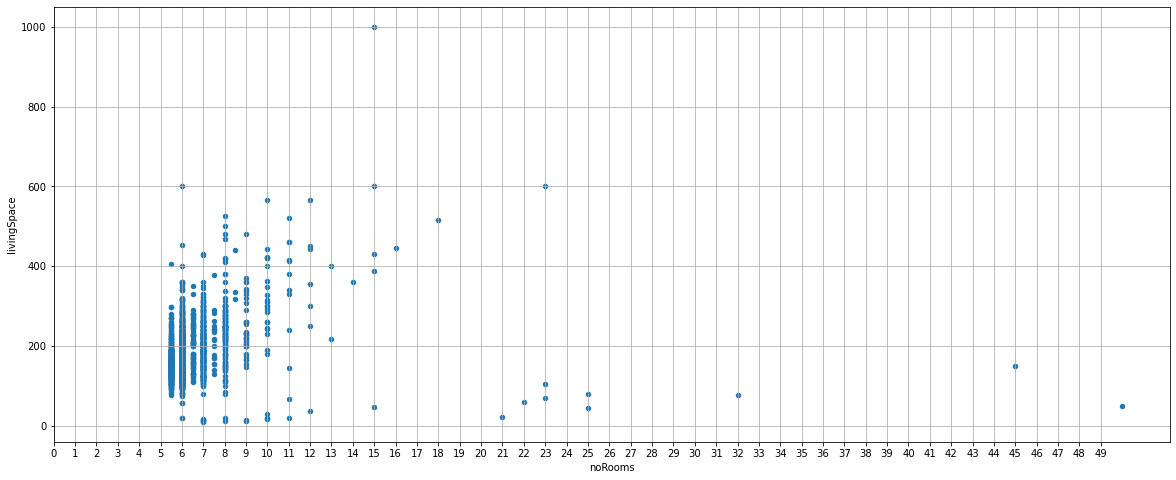

In [138]:
#Plot noRooms against baseRent to see how they relate.
rentals[rentals.noRooms > 5].plot.scatter(x = 'noRooms', y = 'livingSpace', figsize = (20, 8))
plt.xticks(np.arange(0, 50, step= 1))
plt.grid();

We notice a general upward trend of number of rooms with livingSpace till 10 rooms. We can assume the standard room size to be 7.5 and review entries where the livingSpace is less than the noRooms times this rooms size. 

In [139]:
#Check rooms with livingSpace less than 7.5 x noRooms
min_room_area = 7.5
rentals.loc[(rentals.livingSpace < min_room_area * rentals.noRooms), space_cols + rent_cols]

,noRooms,livingSpace,baseRent,totalRent
2134,4.00,16.00,291.87,389.16
6961,3.00,19.00,227.50,325.00
11013,8.00,12.00,135.00,135.00
28155,9.00,12.00,300.00,400.00
32032,3.00,13.00,400.00,400.00
...,...,...,...,...
259041,5.00,18.00,250.00,NaN
260286,4.00,10.00,990.00,1315.00
262397,3.00,14.00,650.00,650.00
264039,6.00,20.00,250.00,300.00


In [140]:
#Filter the above units from the dataset
rentals = rentals[~(rentals.livingSpace < min_room_area * rentals.noRooms)]

#### 5.6.9 thermalChar 

- thermalChar indicates energy demand of apartment. Data owner noted that it is used to determine energyEfficiencyClass. Has unit - kWh/(m^2a) [Kilowatt per square meter per annum] Determined that ~ 40% of its values are missing. Has a min value of 0.1 and max value of 1996. Values seem extreme. 


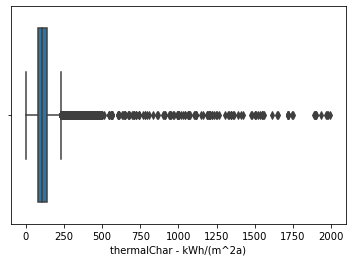

In [141]:
_= sns.boxplot(x = 'thermalChar', data = rentals)
_= plt.xlabel('thermalChar - kWh/(m^2a)')

- For typical apartment building, thermalChar is between 20 and 120 KWh / (m^2a)

In [142]:
cols4 = ['baseRent','noRooms','livingSpace', 'condition', \
        'interiorQual', 'firingTypes', 'yearConstructed', 'thermalChar']
rentals.loc[rentals.thermalChar > 1200, cols4].sort_values(by = 'thermalChar', ascending = False)

,baseRent,noRooms,livingSpace,condition,interiorQual,firingTypes,yearConstructed,thermalChar
71601,650.00,4.00,105.63,unknown,unknown,NaN,NaT,1996.00
123270,374.00,2.00,67.00,unknown,unknown,district_heating,1983-01-01,1983.00
57965,308.00,3.00,61.03,well_kept,normal,district_heating,1974-01-01,1974.00
217982,800.00,3.00,80.00,well_kept,unknown,gas,1968-01-01,1971.00
246864,1200.00,3.00,110.00,mint_condition,unknown,NaN,2017-01-01,1932.00
122066,265.00,2.00,44.80,unknown,unknown,gas,NaT,1900.00
101444,265.00,2.00,44.80,unknown,unknown,gas,NaT,1900.00
204426,173.00,1.00,35.38,unknown,normal,gas,1897-01-01,1897.00
262421,173.00,1.00,35.38,unknown,normal,gas,1897-01-01,1897.00
46204,550.00,3.00,76.00,mint_condition,sophisticated,NaN,2018-01-01,1890.00


- 123270 and 57965 are dates. We will remove these rows

In [143]:
rentals = rentals.loc[~rentals.index.isin([123270, 57965])]

In [144]:
rentals.loc[rentals.thermalChar < 1, cols4].sort_values(by = 'thermalChar')

,baseRent,noRooms,livingSpace,condition,interiorQual,firingTypes,yearConstructed,thermalChar
21962,624.00,3.00,78.00,well_kept,unknown,oil,1968-01-01,0.10
57693,695.00,2.00,46.23,first_time_use,sophisticated,natural_gas_light,2018-01-01,0.20
53510,1195.00,3.00,105.78,first_time_use,unknown,gas,2019-01-01,0.20
47158,1195.00,3.00,105.78,first_time_use,luxury,gas,2019-01-01,0.20
125961,1195.00,3.00,105.78,first_time_use,luxury,gas,2019-01-01,0.20
127217,1590.00,3.00,92.00,first_time_use_after_refurbishment,sophisticated,coal_coke,2019-01-01,0.25
156348,764.64,2.00,70.80,first_time_use,sophisticated,district_heating,2017-01-01,0.27
228995,360.00,2.50,55.00,modernized,sophisticated,gas,1965-01-01,0.28
31114,1195.00,3.00,61.30,first_time_use,sophisticated,gas,2017-01-01,0.30
30229,1050.00,2.00,50.80,first_time_use,sophisticated,gas,2017-01-01,0.30


- thermalChar has low values for mostly apartments that have had some work done to them (e.g. first_time_use, full_renovated, etc.)

In [145]:
#Determine high thermalChar threshold
high_thermalChar = rentals.thermalChar.quantile(0.9999)
high_thermalChar

1717.9

In [146]:
#Remove values of thermalChar greater than 1718
rentals = rentals[~(rentals.thermalChar > high_thermalChar)]

In [147]:
rentals.thermalChar.describe()

count   161758.00
mean       114.65
std         59.54
min          0.10
25%         79.00
50%        107.00
75%        140.40
max       1717.90
Name: thermalChar, dtype: float64

In [148]:
#Check proportion of missing values for livingSpace
rentals.thermalChar.isnull().mean()

0.39583699050194404

#### 5.6.10 floor and numberOfFloors

- floor indicates floor number of apartment. Determined that 19% of its values are missing. Has 53 unique values, with min of -1 and max of 999. Min of -1 likely indicates a basement apartment, but a max of 999 is an extreme value. Floor number is an identifier for the apartment specific to the building.
- numberOfFloors indicates the number of floors in the building. Has 57 unique values, with min of 0 and max of 999, similar to 'floor'. 999 is an extreme values.

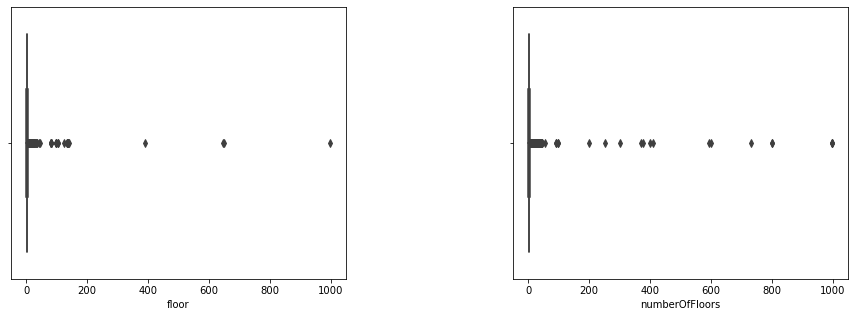

In [149]:
fig, ax = plt.subplots(nrows = 1,ncols = 2, figsize=(15, 5))
_= sns.boxplot(x = 'floor', data = rentals, ax = ax[0])
_= sns.boxplot(x = 'numberOfFloors', data = rentals, ax = ax[1])
plt.subplots_adjust(wspace= 0.5)
plt.show()

- Tallest German building has 56 floors. We will filter with this limit.

In [150]:
#Check stats of floor
rentals.floor.describe()

count   216753.00
mean         2.12
std          3.64
min         -1.00
25%          1.00
50%          2.00
75%          3.00
max        999.00
Name: floor, dtype: float64

In [151]:
#Check stats of numberOfFloors
rentals.numberOfFloors.describe()

count   170455.00
mean         3.57
std          6.39
min          0.00
25%          2.00
50%          3.00
75%          4.00
max        999.00
Name: numberOfFloors, dtype: float64

In [152]:
#Remove units with numberOfFloors and floor greater than 56
rentals = rentals[~((rentals.numberOfFloors > 56) | (rentals.floor > 56))]

In [153]:
rentals.shape

(267692, 52)

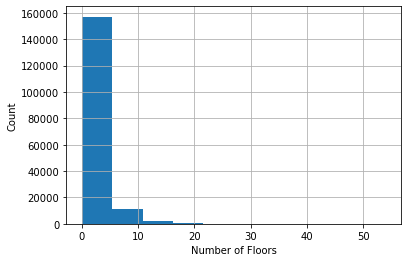

In [154]:
#Review distribution
_= rentals.numberOfFloors.hist()
_= plt.xlabel('Number of Floors')
_= plt.ylabel('Count')

### electrictyBasePrice

In [155]:
rentals.electricityBasePrice.describe()

count   46657.00
mean       89.12
std         5.39
min        71.43
25%        90.76
50%        90.76
75%        90.76
max        90.76
Name: electricityBasePrice, dtype: float64

We observe that at least 75% of the dataset has an electrictyBasePrice of 90.76, meaning that there is not much variation offered by this feature. Furthermore, this feature has information for just over 46k units, implying that there are many missing values. We will drop this feature as a result.

### electrictyKwhPrice

In [156]:
rentals.electricityKwhPrice.describe()

count   46657.00
mean        0.20
std         0.01
min         0.17
25%         0.19
50%         0.20
75%         0.21
max         0.23
Name: electricityKwhPrice, dtype: float64

In [157]:
#Check missing values proportion
rentals.electricityKwhPrice.isnull().mean()

0.8257064088579412

Similar to electrictyBasePrice, electricityKwhPrice has many missing values. Furthermore, the standard devation in available values is 0.01, implying very little variation in the dataset. We will drop this feature accordingly. 

### Reviewing Range Information <br>(yearConstructedRange, baseRentRange, noRoomsRange, livingSpaceRange)</br>

- yearConstructedRange indicates binned construction years from 1 to 9. Determined that 21% of its values are missing, corresponding to the number of missing values for 'yearConstructed'. These are correlated features. Will drop this feature because it likely includes outliers.
- baseRentRange indicates binned base rent. Correlates directly with baseRent. Will drop this feature because it likely includes outliers.
- noRoomsRange indicates binned number of rooms 1 to 5. Redundant feature. Will drop this feature because it likely includes outliers.
- livingSpaceRange is the size of apartment sorted into 7 categories. Redundant feature. Will drop this feature because it likely includes outliers.

## 5.7 Review of Boolean Features

In [158]:
rentals.select_dtypes('boolean').head()

,newlyConst,balcony,hasKitchen,cellar,lift,garden
0,False,False,False,True,False,True
1,False,True,False,False,False,False
2,True,True,False,True,True,False
3,False,True,False,False,False,False
4,False,True,False,False,False,False


In [159]:
#Review missing values
rentals.select_dtypes('boolean').isna().sum()

newlyConst    0
balcony       0
hasKitchen    0
cellar        0
lift          0
garden        0
dtype: int64

## 5.8 Review Datatime Features 

In [160]:
rentals.select_dtypes('datetime').head()

,yearConstructed,lastRefurbish,date
0,1965-01-01,NaT,2019-05-01
1,1871-01-01,2019-01-01,2019-05-01
2,2019-01-01,NaT,2019-10-01
3,1964-01-01,NaT,2019-05-01
4,1950-01-01,NaT,2020-02-01


### 5.8.1 yearConstructed

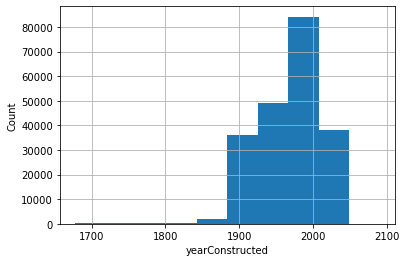

In [161]:
#Plot distribution
_ = rentals.yearConstructed.dt.year.hist()
_= plt.xlabel('yearConstructed')
_= plt.ylabel('Count')

- There are dates past 2020

In [162]:
rentals.loc[rentals.yearConstructed.dt.year >= 2026, select + ['yearConstructed']]

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date,yearConstructed
40265,1,Groß-Berliner_Damm,Johannisthal_Treptow,Berlin,Berlin,12487,470.00,590.00,1.00,31.00,2020-02-01,2029-01-01
54595,57,Gerbermühlstraße,Sachsenhausen_Nord,Frankfurt_am_Main,Hessen,60594,2945.00,3385.00,4.00,156.13,2019-10-01,2026-01-01
87221,NaN,NaN,Rastatt,Rastatt,Baden_Württemberg,76437,1175.00,1475.00,4.00,130.64,2019-05-01,2090-01-01
182121,33,Gerbermühlstraße,Sachsenhausen_Nord,Frankfurt_am_Main,Hessen,60594,1620.00,1910.00,3.00,102.44,2019-10-01,2026-01-01
240346,39,Gerbermühlstraße,Sachsenhausen_Nord,Frankfurt_am_Main,Hessen,60594,1435.00,1690.00,3.00,91.07,2019-10-01,2026-01-01


- We observe than many of the units are first-time use. We will remove rows for values in 2029 and 2090 because they are too far out.

In [163]:
#Filter-out outliers
rentals = rentals[~rentals.index.isin([40265, 87221])]
rentals[rentals.yearConstructed.dt.year > 2026]

,regio1,serviceCharge,heatingType,telekomTvOffer,telekomHybridUploadSpeed,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,scoutId,noParkSpaces,firingTypes,hasKitchen,geo_bln,cellar,yearConstructedRange,baseRent,houseNumber,livingSpace,geo_krs,condition,interiorQual,petsAllowed,street,streetPlain,lift,baseRentRange,typeOfFlat,geo_plz,noRooms,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,heatingCosts,energyEfficiencyClass,lastRefurbish,electricityBasePrice,electricityKwhPrice,date,crossfield_service,crossfield_heating,crossfield_all


In [164]:
#Check proportion of missing values for yearConstructed
rentals.yearConstructed.isnull().mean()

0.21347080578280847

We observe that over 20% of the construction date of properties are missing. There is no ready way to impute the missing values for this feature. We expect older properties to fetch less rent, however, we cannot infer this information if missing. We are therefore likely to drop this feature.

### date

In [165]:
rentals.date.value_counts()

2020-02-01    78920
2019-05-01    75738
2019-10-01    66379
2018-09-01    46653
Name: date, dtype: int64

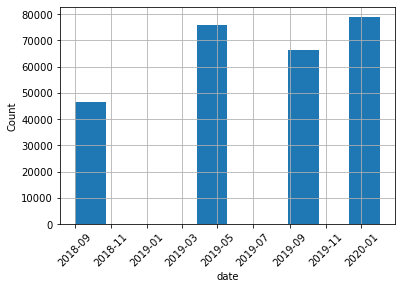

In [166]:
#Plot distribution
rentals.date.hist()
plt.xlabel('date')
plt.xticks(rotation = 45)
plt.ylabel('Count');

We observe that there were more listings on the day the information was scraped in 2020 than 2019 or 2018. This could imply that supply conditions were rising with time. It could also be due to seasonal variation, which we do not have the information for.

### lastRefurbished

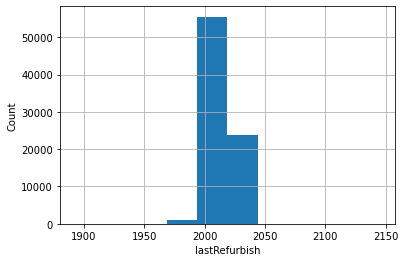

In [167]:
#Plot distribution
_ = rentals.lastRefurbish.dt.year.hist()
_= plt.xlabel('lastRefurbish')
_= plt.ylabel('Count')

In [168]:
#Check proportion of missing values for this feature
rentals.lastRefurbish.isnull().mean()

0.7001905188837835

In [169]:
rentals.lastRefurbish.describe(datetime_is_numeric = True)

count                            80256
mean     2013-11-14 17:50:22.966507520
min                1893-01-01 00:00:00
25%                2012-01-01 00:00:00
50%                2017-01-01 00:00:00
75%                2019-01-01 00:00:00
max                2145-01-01 00:00:00
Name: lastRefurbish, dtype: object

We notice that only 79,938 units have a lastRefurbish date. Over 70% of the values are missing. We can assume that if there is no date provided there were no refurbishments done to the unit, but this is a big assumption for over 70% of the properties. For this reason, we will likely drop this feature from the model. 

Also, we note that the max lastRefurbish date is in 2145, which is an outlier. Let's see units past 2020

In [170]:
rentals.loc[(rentals.lastRefurbish.dt.year > 2020), select + ['lastRefurbish', 'yearConstructed', 'condition']]

,houseNumber,streetPlain,regio3,regio2,regio1,geo_plz,baseRent,totalRent,noRooms,livingSpace,date,lastRefurbish,yearConstructed,condition
112993,NaN,NaN,Kaßberg,Chemnitz,Sachsen,9112,1250.00,NaN,4.00,103.65,2020-02-01,2021-01-01,NaT,first_time_use
144244,53,Augustaanlage,Schwetzingerstadt_/_Oststadt,Mannheim,Baden_Württemberg,68165,482.00,592.00,1.00,38.50,2020-02-01,2021-01-01,1960-01-01,first_time_use_after_refurbishment
175529,2,Eduard_Baring_Str,Uslar,Northeim,Niedersachsen,37170,460.00,660.00,4.00,100.00,2018-09-01,2115-01-01,2014-01-01,fully_renovated
190412,29,Windmühlenstr,Friemersheim,Duisburg,Nordrhein_Westfalen,47229,850.00,1110.00,3.50,120.00,2018-09-01,2118-01-01,NaT,first_time_use_after_refurbishment
197544,41b,Kapellenstraße,Nordost,Wiesbaden,Hessen,65193,715.00,NaN,2.00,62.00,2020-02-01,2145-01-01,2013-01-01,first_time_use_after_refurbishment
226612,16,Mannheimer_Straße,Villingen_Schwenningen,Schwarzwald_Baar,Baden_Württemberg,78048,430.00,NaN,2.00,60.00,2018-09-01,2107-01-01,1987-01-01,need_of_renovation
234573,NaN,NaN,Opladen,Leverkusen,Nordrhein_Westfalen,51379,2159.04,2159.04,2.00,65.00,2020-02-01,2021-01-01,1984-01-01,first_time_use
257979,6,Saarstraße,Schöningen,Helmstedt,Niedersachsen,38364,335.00,NaN,3.00,66.74,2019-05-01,2107-01-01,1956-01-01,well_kept


We notice that many of the lastRefurbish dates in 2021 are for new units. We will leave these. However, For 2115 and 2118, 2107 and 2145, it is likley that these are errors and these dates are actually 2015, 2018, 2017, and 2015 respectively. We will make these changes. 

In [171]:
#Replace values of lastRefurbish to a reasonable guess
rentals.loc[rentals.index.values == 175529, 'lastRefurbish'] = pd.to_datetime(str('2015'), format = '%Y')
rentals.loc[rentals.index.values == 190412, 'lastRefurbish'] = pd.to_datetime(str('2018'), format = '%Y')
rentals.loc[rentals.index.values == 197544, 'lastRefurbish'] = pd.to_datetime(str('2015'), format = '%Y')
rentals.loc[rentals.index.values == 257979, 'lastRefurbish'] = pd.to_datetime(str('2017'), format = '%Y')

## Finalizing rentals dataframe

### Reviewing the features

Let us review the features and our plan going forward for them:
- 'regio1' - will retain in dataset and rename to 'state'
- 'serviceCharge' - will retain
- 'heatingType' - will drop from dataset because of inconsistent values
- 'telekomTvOffer' - will retain
- 'telekomHybridUploadSpeed' - will drop from dataset because there is only one value and it has over 80% of entries missing
- 'newlyConst' - will retain
- 'balcony' - will retain
- 'picturecount - will retain for now, but will likely drop feature prior to modelling
- 'pricetrend' - will drop from dataset because we do not know how this value is computed
- 'telekomUploadSpeed'- will retain in dataset
- 'totalRent' - will drop from dataset. feature has inconsistent values and is highly correlated with baseRent
- 'yearConstructed' - will retain for now, but will likely drop feature prior to modelling
- 'scoutId' - will drop this feature because it has all unique values
- 'noParkSpaces' - will drop this feature. Most of the values are 1 and it has over 60% of values missing
- 'firingTypes' - will drop this feature because of inconsistent values
- 'hasKitchen' - will retain
- 'geo_bln' - will drop this feature because it is the same as regio1
- 'cellar' - will retain
- 'yearConstructedRange' - will drop this feature because it was derived from yearConstructed and is highly correlated with it
- 'baseRent' - will retain
- 'houseNumber' - will drop this feature because the data is no useful
- 'livingSpace' - will retain
- 'geo_krs' - will drop this feature because it is the same as regio2
- 'condition' - will retain
- 'interiorQual' - will retain
- 'petsAllowed' - will retain for now, but will likely drop feature prior to modelling
- 'street' - will drop this feature because it has many unique values and similar information can be derived from the zip code
- 'streetPlain'- will drop this feature because it is the same as street
- 'lift' - will retain
- 'baseRentRange'- will drop this feature because it was derived from baseRent and is highly correlated with it
- 'typeOfFlat' - will retain
- 'geo_plz' - will retain this feature and rename it to zip_code. We need to transform this feature to reduce the number of unique values
- 'noRooms' - will retain
- 'thermalChar' - will retain
- 'floor' - will retain
- 'numberOfFloors' - will retain
- 'noRoomsRange'- will drop this feature because it was derived from noRooms and is highly correlated with it
- 'garden' - will retain
- 'livingSpaceRange'- will drop this feature because it was derived from livingSpace and is highly correlated with it
- 'regio2' - will retain feature and rename it to city_town
- 'regio3' - will retain feature and rename it to municipality
- 'description' - will retain
- 'facilities' - will retain
- 'heatingCosts' - will retain for now, but likely drop it prior to modelling
- 'energyEfficiencyClass' - will drop this feature because over 70% of its values are missing and there is no clear imputation approach
- 'lastRefurbish' - will retain this feature for now, but likely drop feature prior to modelling.
- 'electricityBasePrice' - will drop this feature because only about 40,000 properties have this information and over 75% of these properties have a value of 90.76, suggesting minimal variability in this feature.
- 'electricityKwhPrice' - will drop this feature because over 82% of entries are missing an the standard deviation of existing values is 0.01 suggested minimal variability of this feature
- 'date' - will retain
- 'crossfield_service' - will drop feature. Feature was created during processing
- 'crossfield_heating'- will drop feature. Feature was created during processing
- 'crossfield_all'- will drop feature. Feature was created during processing

In [172]:
#Create list of features to drop and count them
features_to_drop = ['heatingType', 'telekomHybridUploadSpeed', 'pricetrend', 'totalRent', 'scoutId', 'noParkSpaces', \
                   'firingTypes', 'geo_bln', 'yearConstructedRange', 'houseNumber', 'geo_krs', 'street', 'streetPlain', \
                   'baseRentRange', 'noRoomsRange', 'livingSpaceRange', 'energyEfficiencyClass', 'electricityBasePrice', \
                   'electricityKwhPrice', 'crossfield_service', 'crossfield_heating', 'crossfield_all']
len(features_to_drop)

22

In [173]:
#Drop features
rentals.drop(columns = features_to_drop, inplace = True)
rentals.shape

(267690, 30)

In [174]:
#Rename features
rentals.rename(columns={'regio1': 'state', 'regio2': 'city_town', 'regio3': 'municipality', 'geo_plz': 'zip_code',
                       'telekomTvOffer': 'tvOffer', 'telekomUploadSpeed': 'internetUploadSpeed'}, inplace=True)

In [175]:
rentals.reset_index(drop = True)

,state,serviceCharge,tvOffer,newlyConst,balcony,picturecount,internetUploadSpeed,yearConstructed,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,petsAllowed,lift,typeOfFlat,zip_code,noRooms,thermalChar,floor,numberOfFloors,garden,city_town,municipality,description,facilities,heatingCosts,lastRefurbish,date
0,Nordrhein_Westfalen,245.00,ONE_YEAR_FREE,False,False,6,10.00,1965-01-01,False,True,595.00,86.00,well_kept,normal,NaN,False,ground_floor,44269,4.00,181.40,1.00,3.00,True,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,NaN,NaT,2019-05-01
1,Rheinland_Pfalz,134.00,ONE_YEAR_FREE,False,True,8,10.00,1871-01-01,False,False,800.00,89.00,refurbished,normal,no,False,ground_floor,67459,3.00,NaN,NaN,NaN,False,Rhein_Pfalz,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,NaN,NaN,2019-01-01,2019-05-01
2,Sachsen,255.00,ONE_YEAR_FREE,True,True,8,2.40,2019-01-01,False,True,965.00,83.80,first_time_use,sophisticated,NaN,True,apartment,1097,3.00,NaN,3.00,4.00,False,Dresden,Äußere_Neustadt_Antonstadt,Der Neubau entsteht im Herzen der Dresdner Neu...,"* 9 m² Balkon\n* Bad mit bodengleicher Dusche,...",NaN,NaT,2019-10-01
3,Sachsen,58.15,ONE_YEAR_FREE,False,True,9,40.00,1964-01-01,False,False,343.00,58.15,unknown,unknown,NaN,False,other,9599,3.00,86.00,3.00,NaN,False,Mittelsachsen,Freiberg,Abseits von Lärm und Abgasen in Ihre neue Wohn...,NaN,87.23,NaT,2019-05-01
4,Bremen,138.00,NONE,False,True,19,NaN,1950-01-01,False,False,765.00,84.97,refurbished,unknown,NaN,False,apartment,28213,3.00,188.90,1.00,NaN,False,Bremen,Neu_Schwachhausen,Es handelt sich hier um ein saniertes Mehrfami...,Diese Wohnung wurde neu saniert und ist wie fo...,NaN,NaT,2020-02-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267685,Bayern,90.00,ONE_YEAR_FREE,False,True,0,10.00,2016-01-01,False,True,820.00,90.00,mint_condition,sophisticated,no,False,roof_storey,82390,3.00,NaN,NaN,NaN,False,Weilheim_Schongau,Eberfing,"Diese schöne, neuwertige Wohnung im Dachgescho...",Fliesen und Parkett. Sichtbarer Dachstuhl.,NaN,NaT,2020-02-01
267686,Hessen,220.00,NONE,False,True,12,NaN,1983-01-01,True,False,930.00,115.00,well_kept,sophisticated,negotiable,False,apartment,68519,3.50,NaN,1.00,1.00,False,Bergstraße,Viernheim,Hier wird eine Wohnung im 2 Familienhaus angeb...,"Parkett, Kamin, Badewanne&Dusche\nGroßer Balko...",NaN,2015-01-01,2019-05-01
267687,Hessen,220.00,ONE_YEAR_FREE,False,True,21,40.00,1965-01-01,False,True,650.00,95.00,well_kept,unknown,negotiable,False,apartment,65552,4.00,160.77,1.00,2.00,True,Limburg_Weilburg,Limburg_an_der_Lahn,gemütliche 4-Zimmer-Wohnung im Obergeschoss ei...,"Böden: Wohn-/Schlafbereich = Laminat, Küche + ...",NaN,2019-01-01,2020-02-01
267688,Nordrhein_Westfalen,175.00,NONE,True,True,16,NaN,2019-01-01,False,True,840.00,70.00,first_time_use,sophisticated,no,True,apartment,51069,2.00,24.70,NaN,5.00,False,Köln,Dellbrück,"Neubau Erstbezug, gehobener Standard, alle Ein...","Wände:\nMaler­vlies, weiß gestrichen alter­nat...",40.00,2019-01-01,2019-05-01


In [176]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267690 entries, 0 to 268849
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   state                267690 non-null  object        
 1   serviceCharge        257456 non-null  float64       
 2   tvOffer              267690 non-null  object        
 3   newlyConst           267690 non-null  bool          
 4   balcony              267690 non-null  bool          
 5   picturecount         267690 non-null  int64         
 6   internetUploadSpeed  234564 non-null  float64       
 7   yearConstructed      210546 non-null  datetime64[ns]
 8   hasKitchen           267690 non-null  bool          
 9   cellar               267690 non-null  bool          
 10  baseRent             267670 non-null  float64       
 11  livingSpace          267690 non-null  float64       
 12  condition            267690 non-null  object        
 13  interiorQual  

## 5.9 State-wide Features

### 5.9.2 State Profile

In [177]:
#Load German states information
states_url = 'https://en.wikipedia.org/wiki/States_of_Germany'
german_states = pd.read_html(states_url)

In [178]:
states = german_states[5]
states

,Coat of arms,Flag,State,Since,Capital,Legislature,Head of government,Governmentcoalition,Bundesrat votes,Area(km2),Population(Dec. 2019)[7],Pop.per km2,HDI(2018)[8],ISO3166-2code,GDP per capita in Euro (2018)[9]
0,NaN,NaN,Baden-Württemberg,1952[10],Stuttgart,Landtag of Baden-Württemberg,Winfried Kretschmann (Greens) Ministerpräsident,"Greens, CDU",6,35752,11100394,310,0.95,BW,47290
1,NaN,NaN,Bavaria(Bayern),1949,Munich(München),Landtag of Bavaria,Markus Söder (CSU) Ministerpräsident,"CSU, FW",6,70552,13124737,185,0.95,BY,48323
2,NaN,NaN,Berlin,1990[11],–,Abgeordnetenhaus,Michael Müller (SPD) Governing Mayor,"SPD, The Left, Greens",4,892,3669491,4086,0.95,BE,41967
3,NaN,NaN,Brandenburg,1990,Potsdam,Landtag of Brandenburg,Dietmar Woidke (SPD) Ministerpräsident,"SPD, CDU, Greens",4,29479,2521893,85,0.91,BB,29541
4,NaN,NaN,Bremen,1949,Bremen,Bürgerschaft of Bremen,Andreas Bovenschulte (SPD) President of the Se...,"SPD, Greens, The Left",3,419,681202,1630,0.95,HB,49215
5,NaN,NaN,Hamburg,1949,–,Bürgerschaft of Hamburg,Peter Tschentscher (SPD) First Mayor,"SPD, Greens",3,755,1847253,2439,0.97,HH,66879
6,NaN,NaN,Hesse(Hessen),1949,Wiesbaden,Landtag of Hesse,Volker Bouffier (CDU) Ministerpräsident,"CDU, Greens",5,21115,6288080,297,0.95,HE,46923
7,NaN,NaN,Lower Saxony(Niedersachsen),1949,Hanover(Hannover),Landtag of Lower Saxony,Stephan Weil (SPD) Ministerpräsident,"SPD, CDU",6,47609,7993448,168,0.92,NI,38423
8,NaN,NaN,Mecklenburg-Western Pomerania (Mecklenburg-Vor...,1990,Schwerin,Landtag of Mecklenburg-Western Pomerania,Manuela Schwesig (SPD) Ministerpräsidentin,"SPD, CDU",3,23180,1609675,69,0.91,MV,28940
9,NaN,NaN,North Rhine-Westphalia(Nordrhein-Westfalen),1949,Düsseldorf,Landtag of North Rhine-Westphalia,Armin Laschet (CDU) Ministerpräsident,"CDU, FDP",6,34085,17932651,526,0.94,NW,39678


In [179]:
state_features = states[['State', 'Area(km2)', 'Population(Dec. 2019)[7]', 'Pop.per km2', 'GDP per capita in Euro (2018)[9]', 'HDI(2018)[8]']]
state_features.head()

,State,Area(km2),Population(Dec. 2019)[7],Pop.per km2,GDP per capita in Euro (2018)[9],HDI(2018)[8]
0,Baden-Württemberg,35752,11100394,310,47290,0.95
1,Bavaria(Bayern),70552,13124737,185,48323,0.95
2,Berlin,892,3669491,4086,41967,0.95
3,Brandenburg,29479,2521893,85,29541,0.91
4,Bremen,419,681202,1630,49215,0.95


In [180]:
state_features.columns = ['state', 'area_km2', 'population_2019', 'population_per_km2_2019', 'gdp_per_capita_2018', 'hdi_2018']
state_features.head()

,state,area_km2,population_2019,population_per_km2_2019,gdp_per_capita_2018,hdi_2018
0,Baden-Württemberg,35752,11100394,310,47290,0.95
1,Bavaria(Bayern),70552,13124737,185,48323,0.95
2,Berlin,892,3669491,4086,41967,0.95
3,Brandenburg,29479,2521893,85,29541,0.91
4,Bremen,419,681202,1630,49215,0.95


In [181]:
#Check names of states
wiki_states = list(state_features.state.unique())
wiki_states

['Baden-Württemberg',
 'Bavaria(Bayern)',
 'Berlin',
 'Brandenburg',
 'Bremen',
 'Hamburg',
 'Hesse(Hessen)',
 'Lower Saxony(Niedersachsen)',
 'Mecklenburg-Western Pomerania (Mecklenburg-Vorpommern)',
 'North Rhine-Westphalia(Nordrhein-Westfalen)',
 'Rhineland-Palatinate(Rheinland-Pfalz)',
 'Saarland',
 'Saxony(Sachsen)',
 'Saxony-Anhalt(Sachsen-Anhalt)',
 'Schleswig-Holstein',
 'Thuringia(Thüringen)']

We notice that some of the states have multiple names. Let us chose a name that corresponds to the names in our rentals dataset.

In [182]:
#Check state names in rentals dataset
rentals_states = list(rentals.state.unique())
rentals_states

['Nordrhein_Westfalen',
 'Rheinland_Pfalz',
 'Sachsen',
 'Bremen',
 'Schleswig_Holstein',
 'Baden_Württemberg',
 'Thüringen',
 'Hessen',
 'Niedersachsen',
 'Bayern',
 'Hamburg',
 'Sachsen_Anhalt',
 'Mecklenburg_Vorpommern',
 'Berlin',
 'Brandenburg',
 'Saarland']

In [183]:
#Change state names from state_features dataframe to state names from rentals dataframe
for wiki_state in wiki_states:
    for rentals_state in rentals_states:
        if fuzz.WRatio(wiki_state, rentals_state) > 80:
            state_features.state = state_features.state.replace(wiki_state, rentals_state)
            
state_features.state    

0          Baden_Württemberg
1                     Bayern
2                     Berlin
3                Brandenburg
4                     Bremen
5                    Hamburg
6                     Hessen
7                    Sachsen
8     Mecklenburg_Vorpommern
9        Nordrhein_Westfalen
10           Rheinland_Pfalz
11                  Saarland
12                   Sachsen
13                   Sachsen
14        Schleswig_Holstein
15                 Thüringen
Name: state, dtype: object

In [184]:
state_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   state                    16 non-null     object 
 1   area_km2                 16 non-null     int64  
 2   population_2019          16 non-null     int64  
 3   population_per_km2_2019  16 non-null     int64  
 4   gdp_per_capita_2018      16 non-null     int64  
 5   hdi_2018                 16 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 896.0+ bytes


# 6. Summary

- We started with a rentals dataframe of 268,850 rows and 49 columns
- We concluded with a rentals dataframe of 267,690 rows and 30 columns
- We removed duplicated rows
- We removed redundant columns that had high cardinality and offered no clear benefits
- We removed columns that were aggregrate values of other columns. These were columns with binned data derived from other columns
- We removed rows with missing rent information
- We removed rows with outlier values for particular numerical features
- We imported data associated with state-wise features
- Finally, we chose the baseRent feature as our target feature.

# 7. Saving New Dataframes

In [185]:
datapath = '..\data\processed'
if not os.path.exists(datapath):
    os.mkdir(datapath)

In [186]:
datapath_rentals = os.path.join(datapath, 'rentals_cleaned_final.csv')
if not os.path.exists(datapath_rentals):
    rentals.to_csv(datapath_rentals, index=False)

In [187]:
datapath_state_features = os.path.join(datapath, 'state_features_final.csv')
if not os.path.exists(datapath_state_features):
    state_features.to_csv(datapath_state_features, index=False)